In [1]:
seed_value= 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import pickle
import math

#Scikit-Learn Importing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from scipy.stats.mstats import gmean, kurtosis, skew

#Import PyWavelets for WaveSmoothing
import pywt
import mad
from statsmodels import robust

#Import Keras
import keras
from keras.layers import Input, Dense, BatchNormalization, Dropout, LSTM, RepeatVector, TimeDistributed
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from tqdm import tqdm
from keras.callbacks import History 
history = History()
from keras import backend as K

#Import Gridsearch
from hypopt import GridSearch

#Import Capstone Functions
from Capstone_Functions import *
cf = CapstoneFunctions()

#Import PyFolio
import pyfolio as pf

#Import Seaborn
import seaborn as sns

In [3]:
Monthly = pd.read_pickle('data/Monthly.pkl')
Monthly2 = pd.read_pickle('data/MonthlyReturns.pkl')

In [4]:
WOMonthly = Monthly.iloc[:,14:15].copy()
WOMonthly.head()

WOMonthly
date                 
1990-12-03   0.052244
1991-01-01   0.011277
1991-02-01   0.015239
1991-03-01   0.096461
1991-04-01   0.026566

In [5]:
FIPMonthly = Monthly2.iloc[:,16:17].copy()
FIPMonthly.head()

FIPMonthly
date                  
1990-12-03    0.034620
1991-01-01    0.022021
1991-02-01    0.013218
1991-03-01    0.089188
1991-04-01    0.031861

In [6]:
SandP = pd.read_excel('S&P.xlsx', index_col="date")
SandP = SandP.copy()
SandP_Monthly = SandP.resample('BMS').first()
SandPreturns = SandP_Monthly.pct_change().dropna()
SandPreturnsMonthly = SandPreturns.loc['1990-12-03':]
SandPreturnsMonthly.head()

sandp
date                
1990-12-03  0.055632
1991-01-01  0.018883
1991-02-01  0.038853
1991-03-01  0.079930
1991-04-01  0.002240

In [7]:
Tbills = pd.read_excel('Bills.xlsx', index_col="date")
Tbills = Tbills.copy()
Tbills = Tbills.loc['1990-12-03':]
Tbills.tail()

Bills 
date                
2020-04-01  0.002145
2020-05-01  0.000097
2020-06-01  0.000062
2020-07-01  0.000126
2020-08-03  0.000126

In [8]:
length = (FIPMonthly.shape[0]-100-12)

# LSTM

In [9]:
#Create Train_Test_Split for High and Low Momentum returns with a 60 Month Lookback
WOXdata, WOYdata, WOXtrain, WOYtrain, WOXtest, WOYtest, WOPredictedX, WOForecastX, WOX, WOY = \
cf.Train_Test_Split(WOMonthly, 0, 100, 12, scaler = False)

FIPXdata, FIPYdata, FIPXtrain, FIPYtrain, FIPXtest, FIPYtest, FIPPredictedX, FIPForecastX, FIPX, FIPY = \
cf.Train_Test_Split(FIPMonthly, 0, 100, 12, scaler = False)

In [10]:
def waveletSmooth(x, wavelet="haar", level=2, DecLvl=2):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per", level=DecLvl)
    # calculate a threshold
    sigma = robust.mad(coeff[-level])
    uthresh = sigma * np.sqrt( 2*np.log( len( x )))
    coeff[1:] = (pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:])
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec(coeff, wavelet, mode="per")
    return y

In [11]:
wav_wo = waveletSmooth(WOMonthly.iloc[:,0])
wav_wo = wav_wo.reshape(len(wav_wo),1)

wav_fip = waveletSmooth(FIPMonthly.iloc[:,0])
wav_fip = wav_fip.reshape(len(wav_fip),1)

In [12]:
def Train_Test_Split2(Data1, Window, Lookback): 
    TrainSplit = int(Window*0.9)
    TestSplit = int(Window*0.1)

    #Iterate Through Data and Creat Numpy arrays with 12 Months of \ 
    #lagged data for X and 13th Month for Y
    tmpX=[]
    tmpY=[]
    for A in range(len(Data1)-Lookback):
        tmp=Data1[A:(A + Lookback),0]
        tmpX.append(tmp)
        tmpY.append(Data1[(A + Lookback),0])
    Xdata = np.array(tmpX)
    Ydata = np.array(tmpY)

    tmpForeX=[]
    for A in range(len(Data1)-Lookback):
        tmpFore=Data1[A+1:(A+1 + Lookback),0]
        tmpForeX.append(tmpFore)
    XdataFore = np.array(tmpForeX)

    Ydata = Ydata.reshape(len(Ydata),1)

    Shape = int(Xdata.shape[0])
    Shape2 = int(XdataFore.shape[0])


    #Create Empty Numpy Arrays
    Xtrain=np.ones(shape=(Shape-Window,TrainSplit,12))
    Ytrain=np.ones(shape=(Shape-Window,TrainSplit,1))
    Xtest=np.ones(shape=(Shape-Window,TestSplit,Lookback))
    Ytest=np.ones(shape=(Shape-Window,TestSplit,1))
    PredictedX=np.ones(shape=(Shape-Window,1,Lookback))
    ForecastX=np.ones(shape=(Shape2-Window,1,Lookback))
    X = np.ones(shape=(Shape-Window,Window,Lookback))
    Y = np.ones(shape=(Shape-Window,Window,1))

    #Fill Numpy Arrays with data
    for B in range(Shape-Window):
        Xtrain[B,:,:] = Xdata[B:B+TrainSplit,:]
        Ytrain[B,:,:] = Ydata[B:B+TrainSplit]
        Xtest[B,:,:] = Xdata[B+TrainSplit:B+Window,:]
        Ytest[B,:,:] = Ydata[B+TrainSplit:B+Window]
        PredictedX[B,:,:] = Xdata[B+Window,:]
        ForecastX[B,:,:] = XdataFore[B+Window,:]
        X[B,:,:] = Xdata[B:B+Window,:]
        Y[B,:,:] = Ydata[B:B+Window]

    return Xdata, Ydata, Xtrain, Ytrain, Xtest, Ytest, PredictedX, ForecastX, X, Y

In [13]:
#Create Train_Test_Split for High and Low Momentum returns with a 100 Month Lookback
W_WO_Xdata, W_WO_Ydata, W_WO_Xtrain, W_WO_Ytrain, W_WO_Xtest, W_WO_Ytest, W_WO_ForecastX, \
W_WO_ForecastX, W_WO_X, W_WO_Y = \
Train_Test_Split2(wav_wo, 100, 12)

#Create Train_Test_Split for High and Low Momentum returns with a 100 Month Lookback
W_FIP_Xdata, W_FIP_Ydata, W_FIP_Xtrain, W_FIP_Ytrain, W_FIP_Xtest, W_FIP_Ytest, W_FIP_ForecastX,\
W_FIP_ForecastX, W_FIP_X, W_FIP_Y = \
Train_Test_Split2(wav_fip, 100, 12)

In [14]:
epochs = 200
batch = 100

In [15]:
def LSTM_Reshape(LSTM_Shape):
    LSTM_Shape = LSTM_Shape.reshape((LSTM_Shape.shape[0],LSTM_Shape.shape[1],1))
    return LSTM_Shape

def LSTM_RNN(Xtrain, Ytrain, Xtest, Ytest, Xtrue):
    keras.backend.clear_session()
    LSTM_ = Sequential()
    LSTM_.add(LSTM(8, input_shape = (12,1), return_sequences = True))
    LSTM_.add(Dropout(0.2))
    LSTM_.add(LSTM(8, return_sequences = True))
    LSTM_.add(Dropout(0.2))
    LSTM_.add(LSTM(8, return_sequences = False))
    LSTM_.add(Dropout(0.2))
    LSTM_.add(Dense(1, activation = 'linear'))
    LSTM_.compile(loss='mse', optimizer = Adam(lr = 0.05))
    LSTM_.fit(Xtrain, Ytrain, batch_size = batch, epochs = epochs,
       validation_data = (Xtest, Ytest), shuffle = False, verbose = 0)
    Prediction_ = LSTM_.predict(Xtrue)
    history = LSTM_.fit(Xtrain, Ytrain, batch_size = batch, epochs = epochs,
       validation_data = (Xtest, Ytest), shuffle = False, verbose = 0)
    Prediction_ = LSTM_.predict(Xtrue)
    
    print(history.history.keys())
   
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    plt.show()
    
    return (Prediction_)

def predictLSTM(Xtrain, Ytrain, Xtest, Ytest, XFore):
    Final_Prediction = np.zeros(shape=(244,1))
    for i in range(Final_Prediction.shape[0]):
        Xtrain_Reshape = LSTM_Reshape(Xtrain[i])
        Xtest_Reshape = LSTM_Reshape(Xtest[i])
        XFore_Reshape = LSTM_Reshape(XFore[i])
        Final_Prediction[i] = LSTM_RNN(Xtrain_Reshape, Ytrain[i], Xtest_Reshape, Ytest[i], XFore_Reshape)
        print('Prediction',i+1,'of',244)
    return Final_Prediction

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
dict_keys(['val_loss', 'loss'])


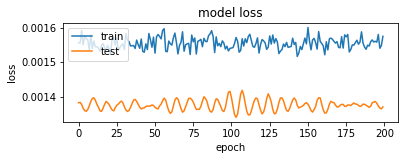

Prediction 1 of 244
dict_keys(['val_loss', 'loss'])


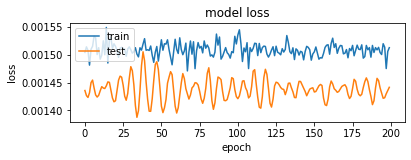

Prediction 2 of 244
dict_keys(['val_loss', 'loss'])


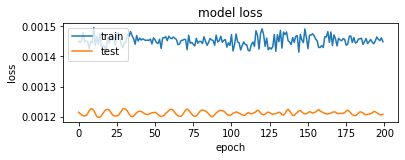

Prediction 3 of 244
dict_keys(['val_loss', 'loss'])


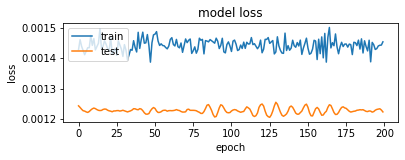

Prediction 4 of 244
dict_keys(['val_loss', 'loss'])


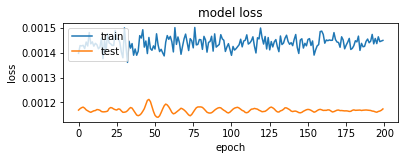

Prediction 5 of 244
dict_keys(['val_loss', 'loss'])


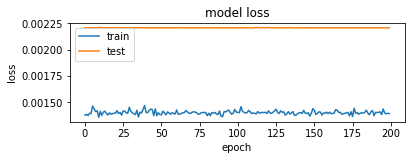

Prediction 6 of 244
dict_keys(['val_loss', 'loss'])


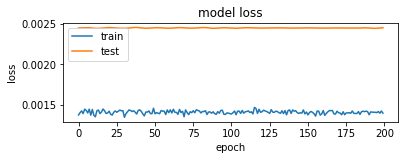

Prediction 7 of 244
dict_keys(['val_loss', 'loss'])


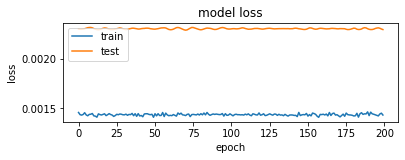

Prediction 8 of 244
dict_keys(['val_loss', 'loss'])


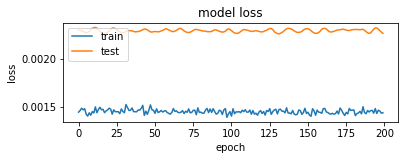

Prediction 9 of 244
dict_keys(['val_loss', 'loss'])


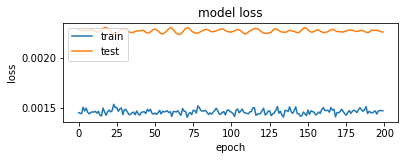

Prediction 10 of 244
dict_keys(['val_loss', 'loss'])


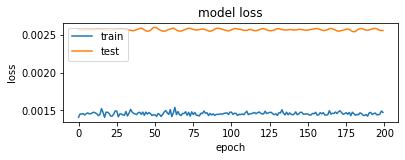

Prediction 11 of 244
dict_keys(['val_loss', 'loss'])


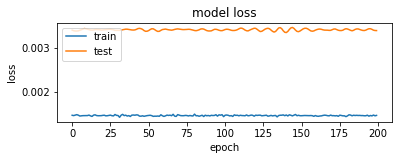

Prediction 12 of 244
dict_keys(['val_loss', 'loss'])


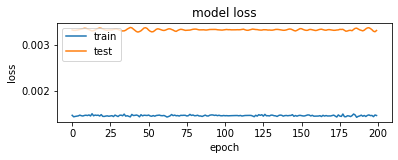

Prediction 13 of 244
dict_keys(['val_loss', 'loss'])


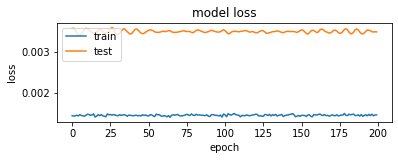

Prediction 14 of 244
dict_keys(['val_loss', 'loss'])


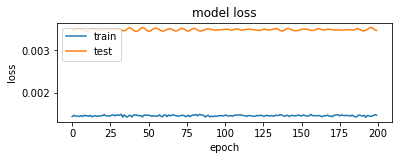

Prediction 15 of 244
dict_keys(['val_loss', 'loss'])


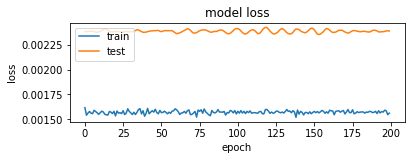

Prediction 16 of 244
dict_keys(['val_loss', 'loss'])


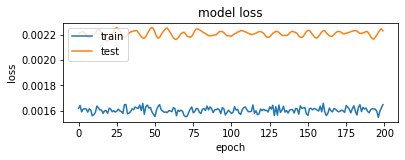

Prediction 17 of 244
dict_keys(['val_loss', 'loss'])


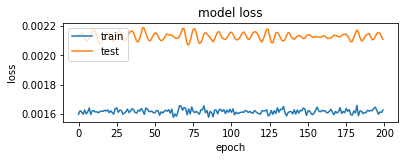

Prediction 18 of 244
dict_keys(['val_loss', 'loss'])


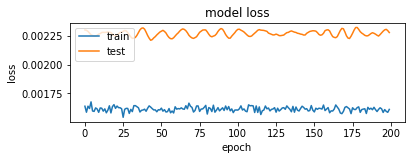

Prediction 19 of 244
dict_keys(['val_loss', 'loss'])


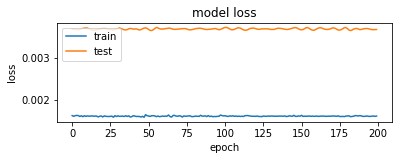

Prediction 20 of 244
dict_keys(['val_loss', 'loss'])


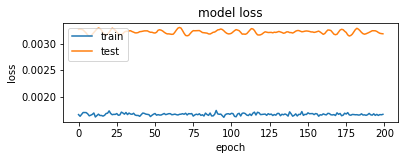

Prediction 21 of 244
dict_keys(['val_loss', 'loss'])


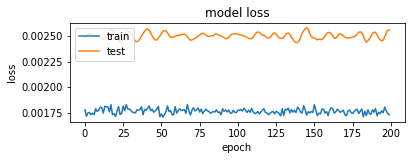

Prediction 22 of 244
dict_keys(['val_loss', 'loss'])


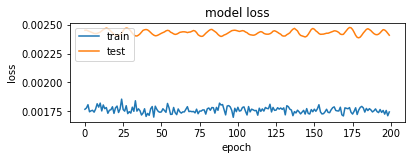

Prediction 23 of 244
dict_keys(['val_loss', 'loss'])


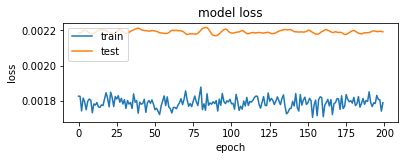

Prediction 24 of 244
dict_keys(['val_loss', 'loss'])


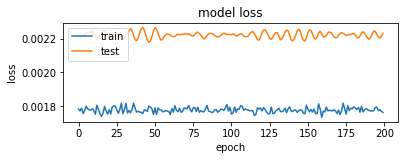

Prediction 25 of 244
dict_keys(['val_loss', 'loss'])


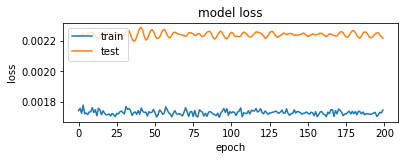

Prediction 26 of 244
dict_keys(['val_loss', 'loss'])


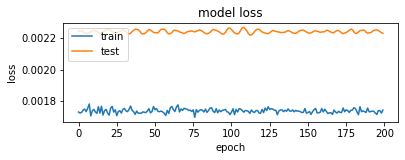

Prediction 27 of 244
dict_keys(['val_loss', 'loss'])


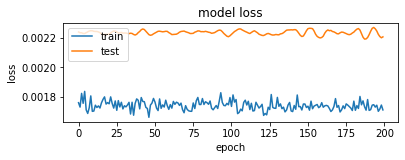

Prediction 28 of 244
dict_keys(['val_loss', 'loss'])


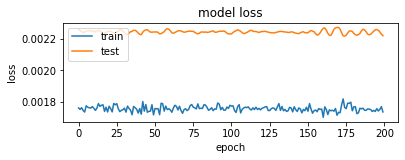

Prediction 29 of 244
dict_keys(['val_loss', 'loss'])


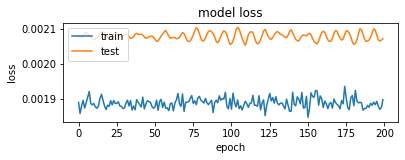

Prediction 30 of 244
dict_keys(['val_loss', 'loss'])


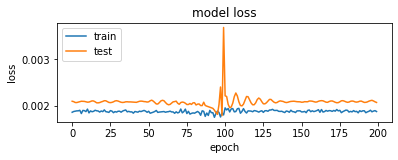

Prediction 31 of 244
dict_keys(['val_loss', 'loss'])


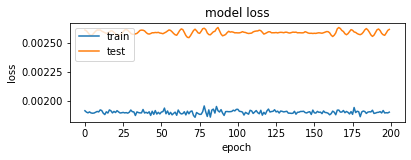

Prediction 32 of 244
dict_keys(['val_loss', 'loss'])


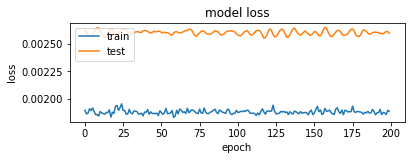

Prediction 33 of 244
dict_keys(['val_loss', 'loss'])


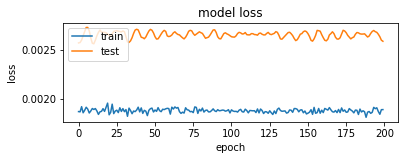

Prediction 34 of 244
dict_keys(['val_loss', 'loss'])


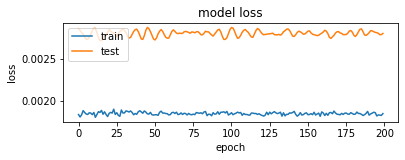

Prediction 35 of 244
dict_keys(['val_loss', 'loss'])


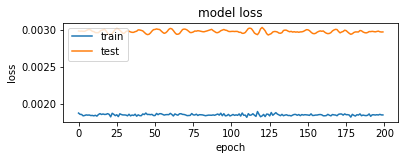

Prediction 36 of 244
dict_keys(['val_loss', 'loss'])


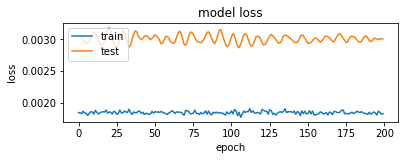

Prediction 37 of 244
dict_keys(['val_loss', 'loss'])


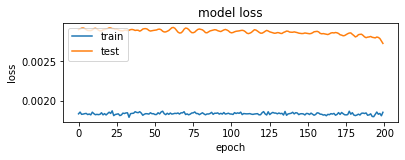

Prediction 38 of 244
dict_keys(['val_loss', 'loss'])


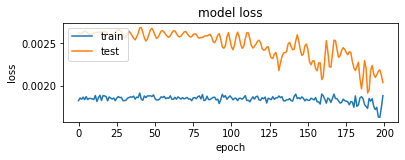

Prediction 39 of 244
dict_keys(['val_loss', 'loss'])


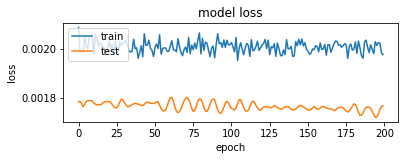

Prediction 40 of 244
dict_keys(['val_loss', 'loss'])


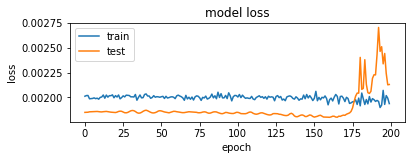

Prediction 41 of 244
dict_keys(['val_loss', 'loss'])


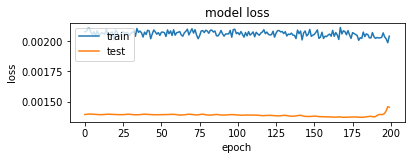

Prediction 42 of 244
dict_keys(['val_loss', 'loss'])


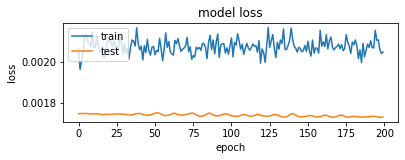

Prediction 43 of 244
dict_keys(['val_loss', 'loss'])


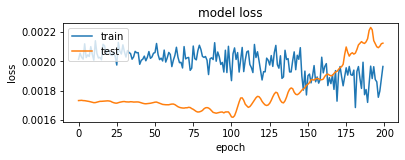

Prediction 44 of 244
dict_keys(['val_loss', 'loss'])


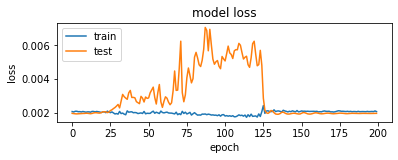

Prediction 45 of 244
dict_keys(['val_loss', 'loss'])


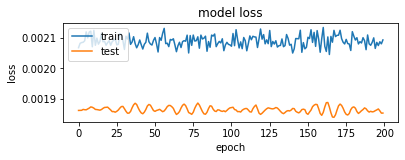

Prediction 46 of 244
dict_keys(['val_loss', 'loss'])


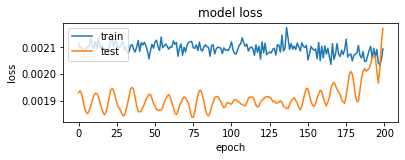

Prediction 47 of 244
dict_keys(['val_loss', 'loss'])


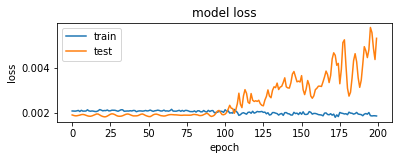

Prediction 48 of 244
dict_keys(['val_loss', 'loss'])


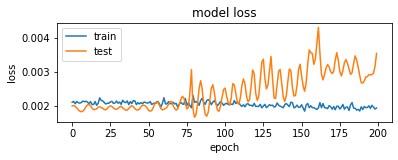

Prediction 49 of 244
dict_keys(['val_loss', 'loss'])


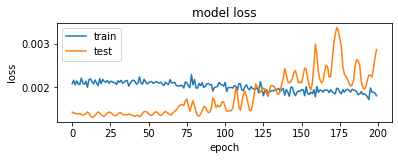

Prediction 50 of 244
dict_keys(['val_loss', 'loss'])


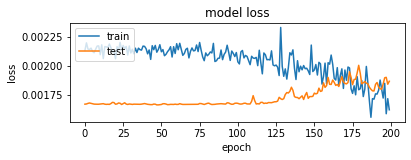

Prediction 51 of 244
dict_keys(['val_loss', 'loss'])


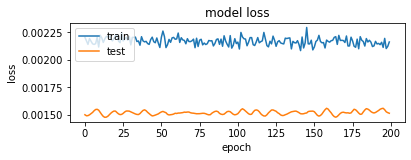

Prediction 52 of 244
dict_keys(['val_loss', 'loss'])


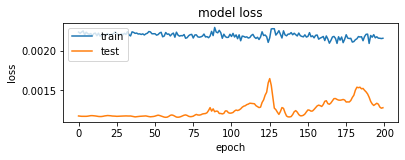

Prediction 53 of 244
dict_keys(['val_loss', 'loss'])


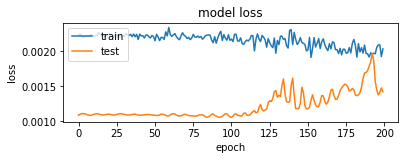

Prediction 54 of 244
dict_keys(['val_loss', 'loss'])


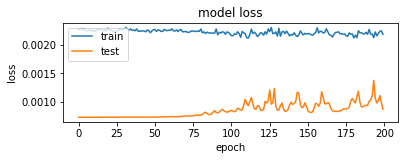

Prediction 55 of 244
dict_keys(['val_loss', 'loss'])


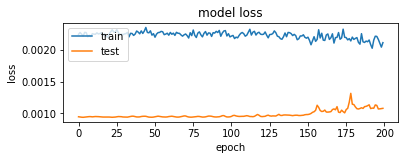

Prediction 56 of 244
dict_keys(['val_loss', 'loss'])


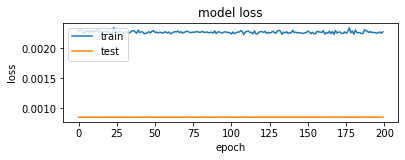

Prediction 57 of 244
dict_keys(['val_loss', 'loss'])


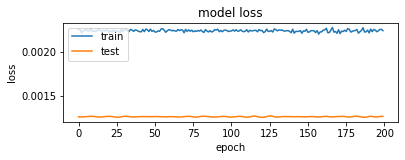

Prediction 58 of 244
dict_keys(['val_loss', 'loss'])


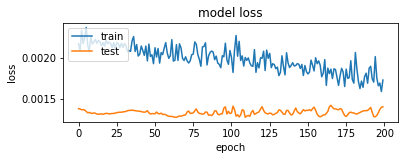

Prediction 59 of 244
dict_keys(['val_loss', 'loss'])


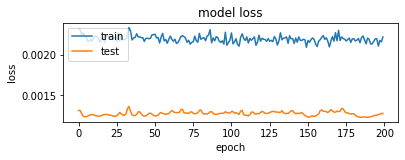

Prediction 60 of 244
dict_keys(['val_loss', 'loss'])


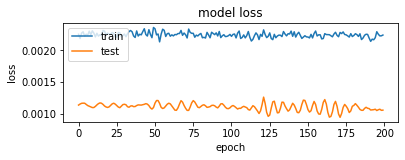

Prediction 61 of 244
dict_keys(['val_loss', 'loss'])


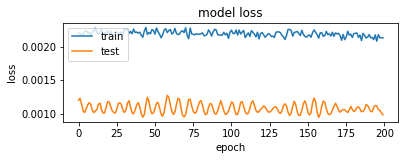

Prediction 62 of 244
dict_keys(['val_loss', 'loss'])


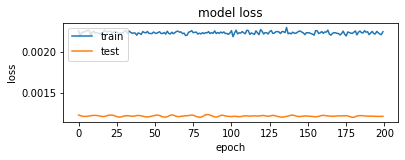

Prediction 63 of 244
dict_keys(['val_loss', 'loss'])


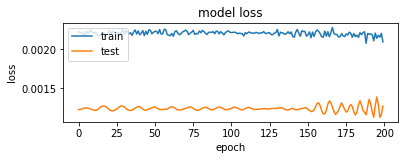

Prediction 64 of 244
dict_keys(['val_loss', 'loss'])


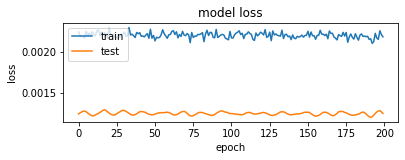

Prediction 65 of 244
dict_keys(['val_loss', 'loss'])


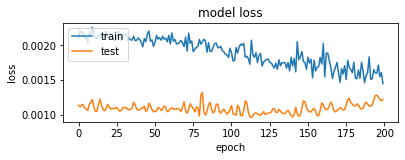

Prediction 66 of 244
dict_keys(['val_loss', 'loss'])


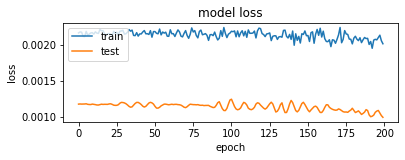

Prediction 67 of 244
dict_keys(['val_loss', 'loss'])


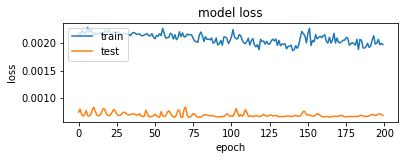

Prediction 68 of 244
dict_keys(['val_loss', 'loss'])


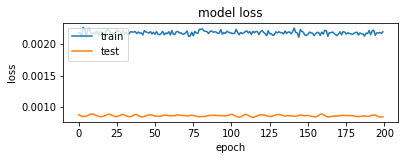

Prediction 69 of 244
dict_keys(['val_loss', 'loss'])


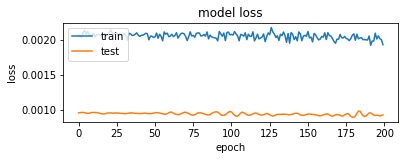

Prediction 70 of 244
dict_keys(['val_loss', 'loss'])


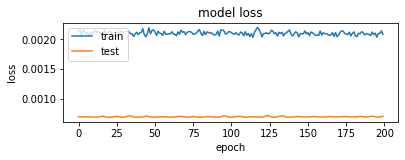

Prediction 71 of 244
dict_keys(['val_loss', 'loss'])


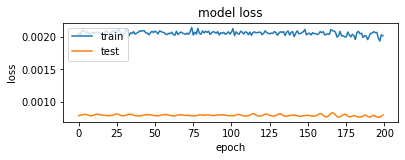

Prediction 72 of 244
dict_keys(['val_loss', 'loss'])


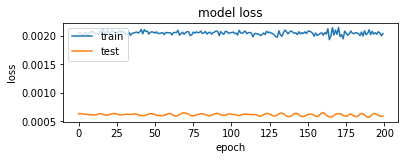

Prediction 73 of 244
dict_keys(['val_loss', 'loss'])


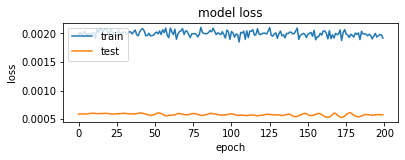

Prediction 74 of 244
dict_keys(['val_loss', 'loss'])


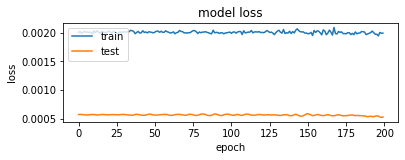

Prediction 75 of 244
dict_keys(['val_loss', 'loss'])


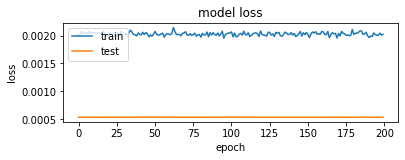

Prediction 76 of 244
dict_keys(['val_loss', 'loss'])


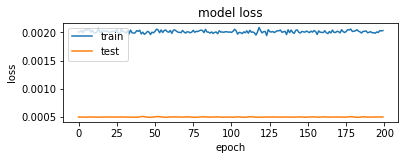

Prediction 77 of 244
dict_keys(['val_loss', 'loss'])


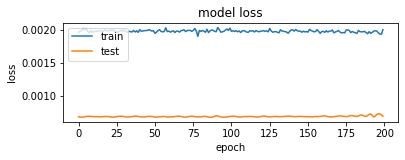

Prediction 78 of 244
dict_keys(['val_loss', 'loss'])


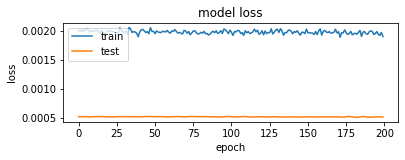

Prediction 79 of 244
dict_keys(['val_loss', 'loss'])


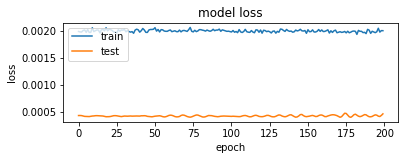

Prediction 80 of 244
dict_keys(['val_loss', 'loss'])


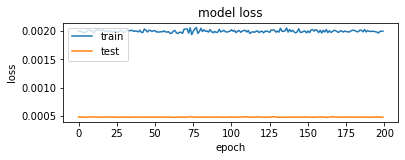

Prediction 81 of 244
dict_keys(['val_loss', 'loss'])


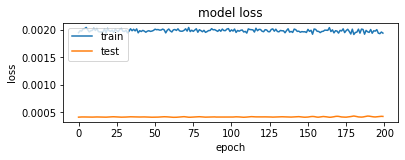

Prediction 82 of 244
dict_keys(['val_loss', 'loss'])


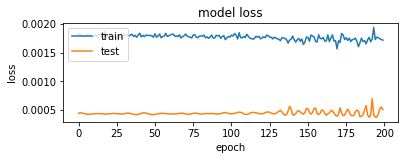

Prediction 83 of 244
dict_keys(['val_loss', 'loss'])


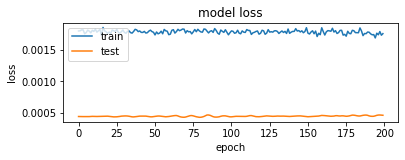

Prediction 84 of 244
dict_keys(['val_loss', 'loss'])


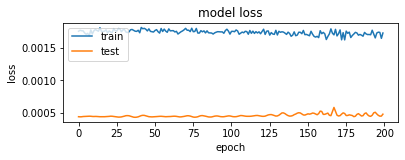

Prediction 85 of 244
dict_keys(['val_loss', 'loss'])


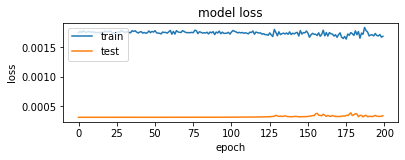

Prediction 86 of 244
dict_keys(['val_loss', 'loss'])


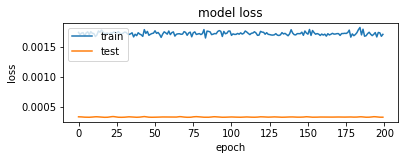

Prediction 87 of 244
dict_keys(['val_loss', 'loss'])


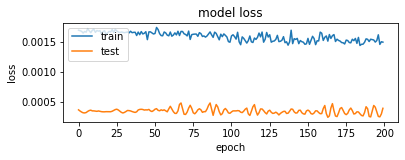

Prediction 88 of 244
dict_keys(['val_loss', 'loss'])


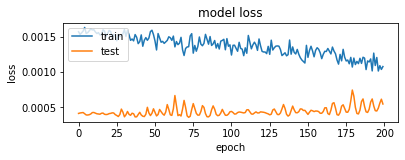

Prediction 89 of 244
dict_keys(['val_loss', 'loss'])


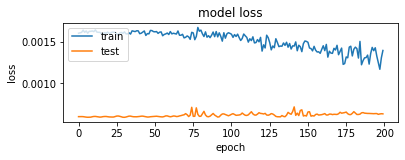

Prediction 90 of 244
dict_keys(['val_loss', 'loss'])


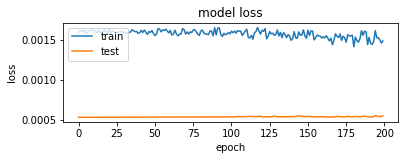

Prediction 91 of 244
dict_keys(['val_loss', 'loss'])


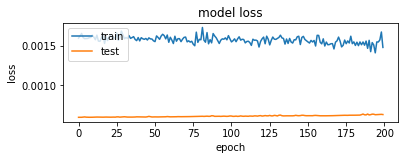

Prediction 92 of 244
dict_keys(['val_loss', 'loss'])


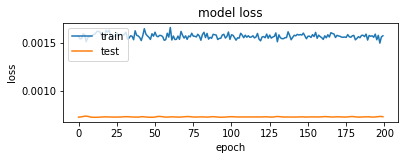

Prediction 93 of 244
dict_keys(['val_loss', 'loss'])


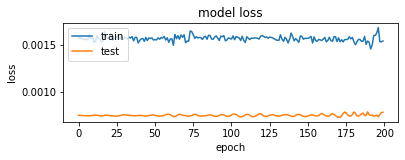

Prediction 94 of 244
dict_keys(['val_loss', 'loss'])


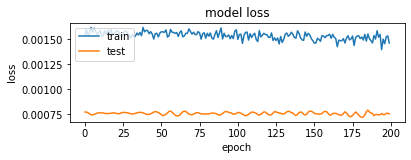

Prediction 95 of 244
dict_keys(['val_loss', 'loss'])


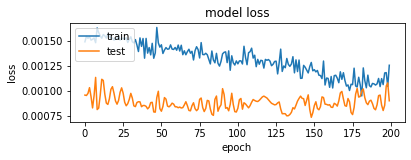

Prediction 96 of 244
dict_keys(['val_loss', 'loss'])


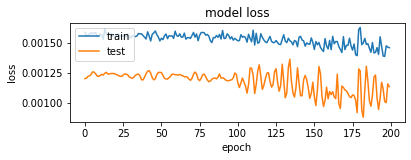

Prediction 97 of 244
dict_keys(['val_loss', 'loss'])


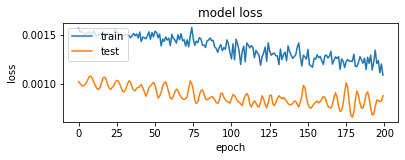

Prediction 98 of 244
dict_keys(['val_loss', 'loss'])


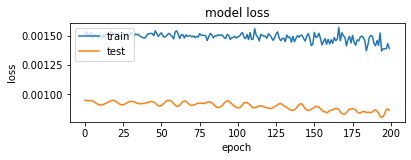

Prediction 99 of 244
dict_keys(['val_loss', 'loss'])


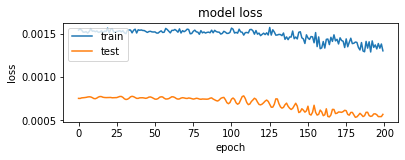

Prediction 100 of 244
dict_keys(['val_loss', 'loss'])


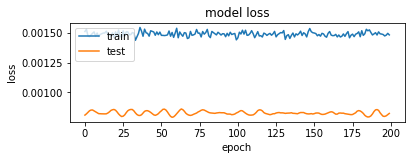

Prediction 101 of 244
dict_keys(['val_loss', 'loss'])


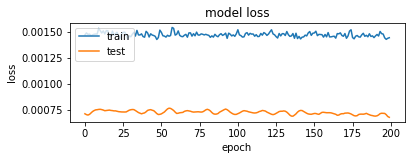

Prediction 102 of 244
dict_keys(['val_loss', 'loss'])


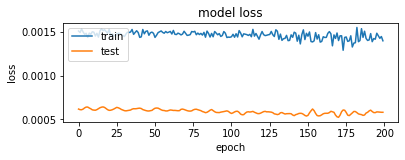

Prediction 103 of 244
dict_keys(['val_loss', 'loss'])


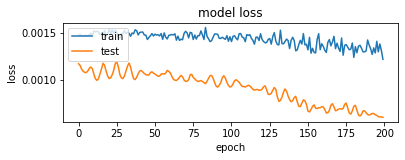

Prediction 104 of 244
dict_keys(['val_loss', 'loss'])


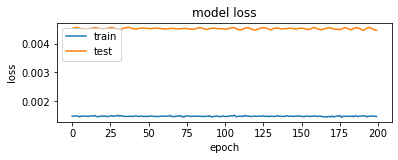

Prediction 105 of 244
dict_keys(['val_loss', 'loss'])


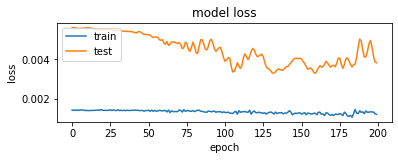

Prediction 106 of 244
dict_keys(['val_loss', 'loss'])


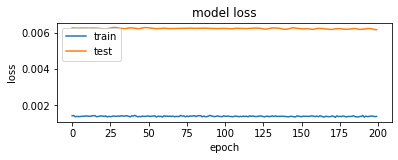

Prediction 107 of 244
dict_keys(['val_loss', 'loss'])


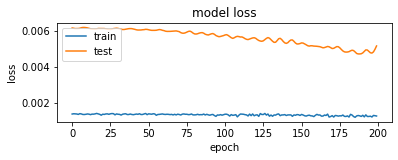

Prediction 108 of 244
dict_keys(['val_loss', 'loss'])


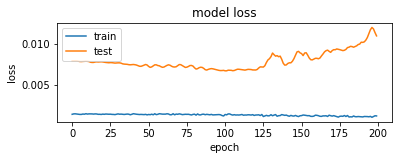

Prediction 109 of 244
dict_keys(['val_loss', 'loss'])


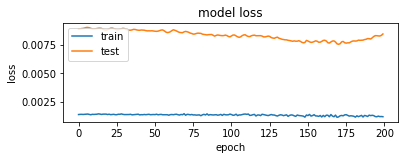

Prediction 110 of 244
dict_keys(['val_loss', 'loss'])


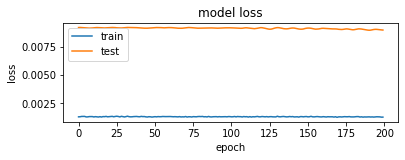

Prediction 111 of 244
dict_keys(['val_loss', 'loss'])


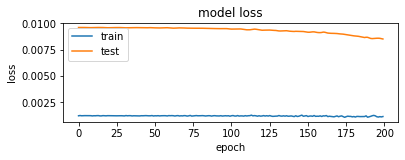

Prediction 112 of 244
dict_keys(['val_loss', 'loss'])


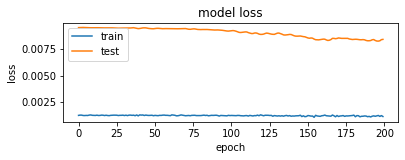

Prediction 113 of 244
dict_keys(['val_loss', 'loss'])


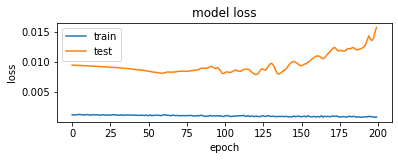

Prediction 114 of 244
dict_keys(['val_loss', 'loss'])


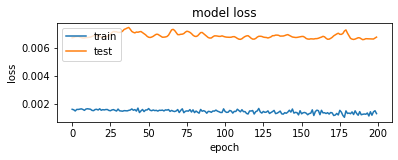

Prediction 115 of 244
dict_keys(['val_loss', 'loss'])


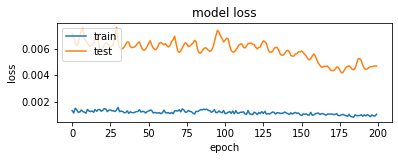

Prediction 116 of 244
dict_keys(['val_loss', 'loss'])


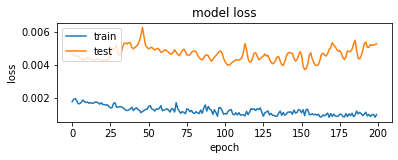

Prediction 117 of 244
dict_keys(['val_loss', 'loss'])


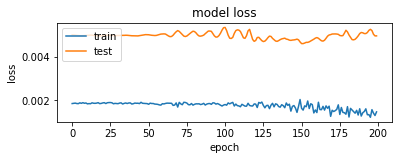

Prediction 118 of 244
dict_keys(['val_loss', 'loss'])


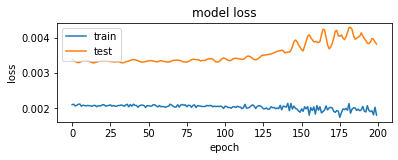

Prediction 119 of 244
dict_keys(['val_loss', 'loss'])


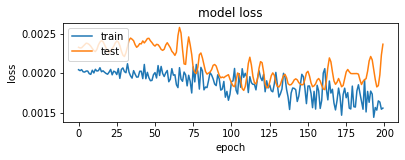

Prediction 120 of 244
dict_keys(['val_loss', 'loss'])


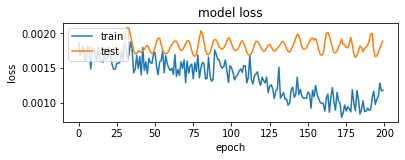

Prediction 121 of 244
dict_keys(['val_loss', 'loss'])


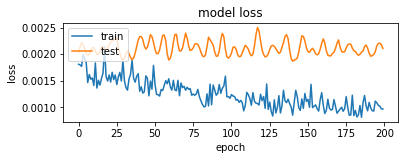

Prediction 122 of 244
dict_keys(['val_loss', 'loss'])


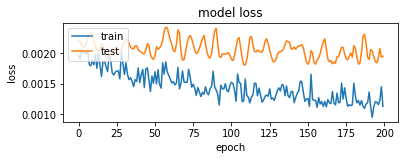

Prediction 123 of 244
dict_keys(['val_loss', 'loss'])


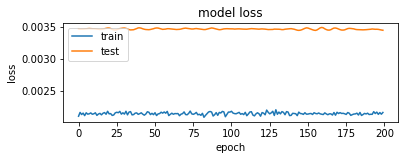

Prediction 124 of 244
dict_keys(['val_loss', 'loss'])


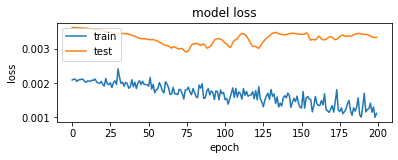

Prediction 125 of 244
dict_keys(['val_loss', 'loss'])


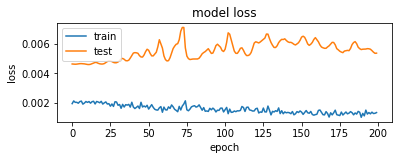

Prediction 126 of 244
dict_keys(['val_loss', 'loss'])


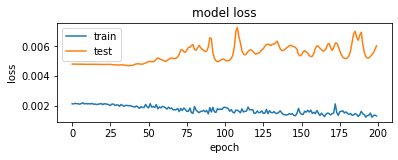

Prediction 127 of 244
dict_keys(['val_loss', 'loss'])


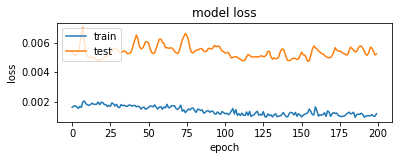

Prediction 128 of 244
dict_keys(['val_loss', 'loss'])


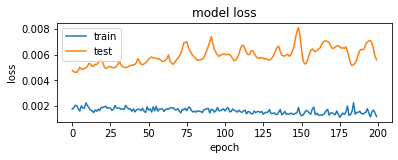

Prediction 129 of 244
dict_keys(['val_loss', 'loss'])


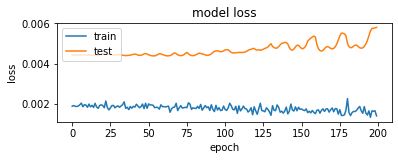

Prediction 130 of 244
dict_keys(['val_loss', 'loss'])


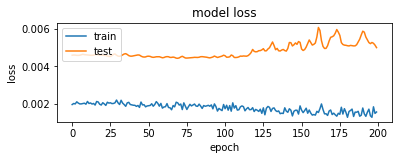

Prediction 131 of 244
dict_keys(['val_loss', 'loss'])


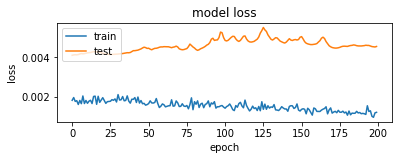

Prediction 132 of 244
dict_keys(['val_loss', 'loss'])


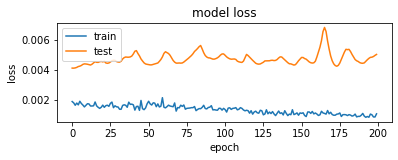

Prediction 133 of 244
dict_keys(['val_loss', 'loss'])


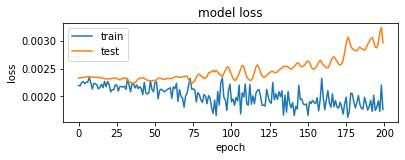

Prediction 134 of 244
dict_keys(['val_loss', 'loss'])


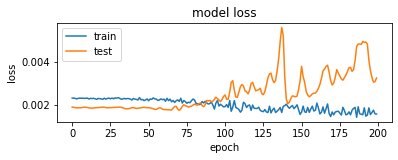

Prediction 135 of 244
dict_keys(['val_loss', 'loss'])


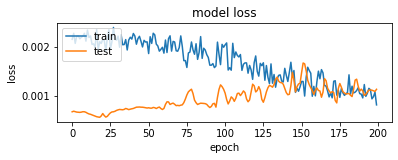

Prediction 136 of 244
dict_keys(['val_loss', 'loss'])


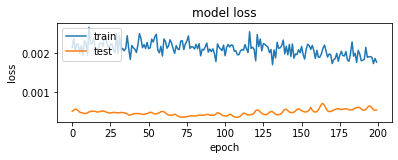

Prediction 137 of 244
dict_keys(['val_loss', 'loss'])


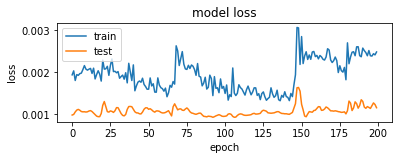

Prediction 138 of 244
dict_keys(['val_loss', 'loss'])


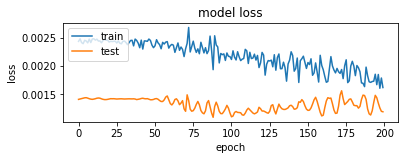

Prediction 139 of 244
dict_keys(['val_loss', 'loss'])


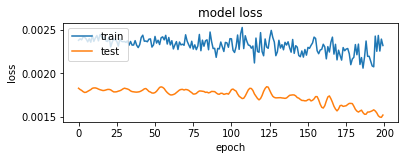

Prediction 140 of 244
dict_keys(['val_loss', 'loss'])


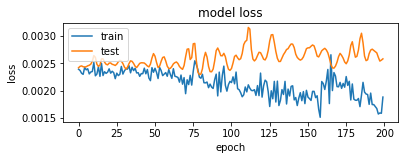

Prediction 141 of 244
dict_keys(['val_loss', 'loss'])


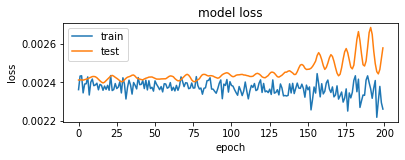

Prediction 142 of 244
dict_keys(['val_loss', 'loss'])


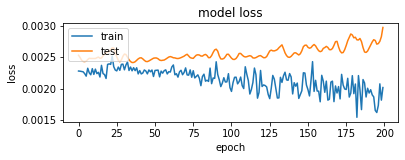

Prediction 143 of 244
dict_keys(['val_loss', 'loss'])


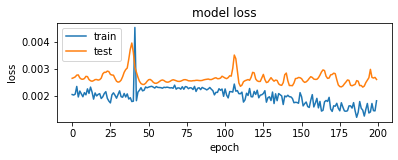

Prediction 144 of 244
dict_keys(['val_loss', 'loss'])


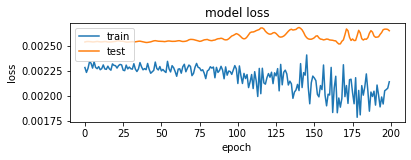

Prediction 145 of 244
dict_keys(['val_loss', 'loss'])


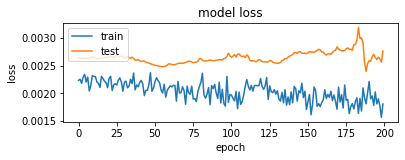

Prediction 146 of 244
dict_keys(['val_loss', 'loss'])


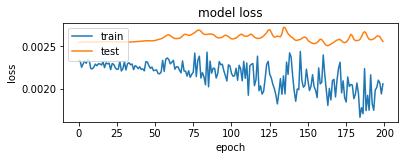

Prediction 147 of 244
dict_keys(['val_loss', 'loss'])


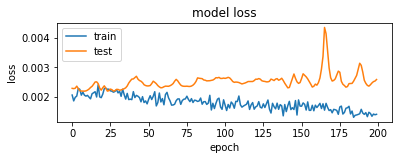

Prediction 148 of 244
dict_keys(['val_loss', 'loss'])


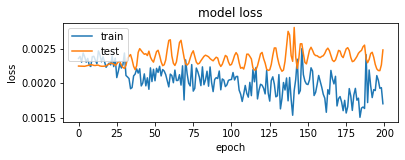

Prediction 149 of 244
dict_keys(['val_loss', 'loss'])


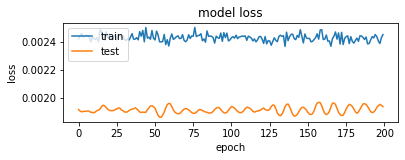

Prediction 150 of 244
dict_keys(['val_loss', 'loss'])


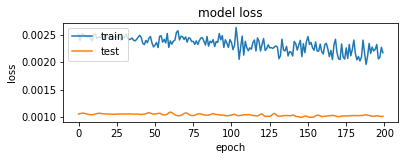

Prediction 151 of 244
dict_keys(['val_loss', 'loss'])


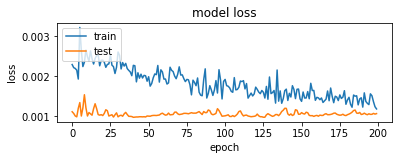

Prediction 152 of 244
dict_keys(['val_loss', 'loss'])


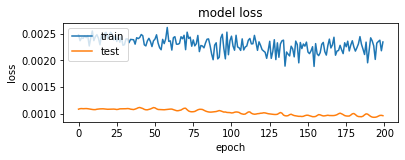

Prediction 153 of 244
dict_keys(['val_loss', 'loss'])


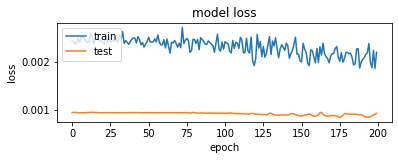

Prediction 154 of 244
dict_keys(['val_loss', 'loss'])


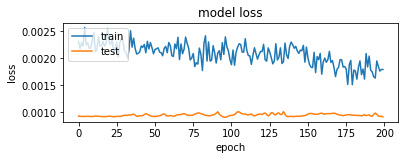

Prediction 155 of 244
dict_keys(['val_loss', 'loss'])


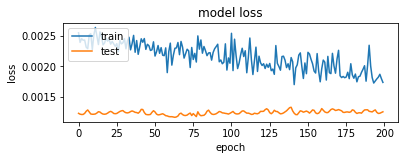

Prediction 156 of 244
dict_keys(['val_loss', 'loss'])


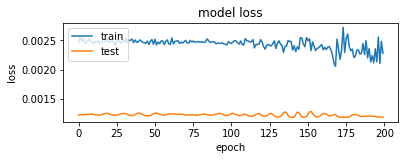

Prediction 157 of 244
dict_keys(['val_loss', 'loss'])


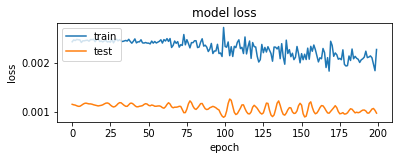

Prediction 158 of 244
dict_keys(['val_loss', 'loss'])


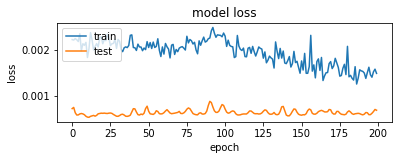

Prediction 159 of 244
dict_keys(['val_loss', 'loss'])


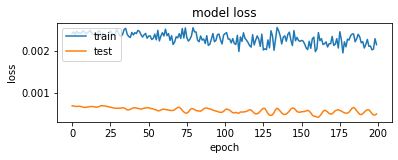

Prediction 160 of 244
dict_keys(['val_loss', 'loss'])


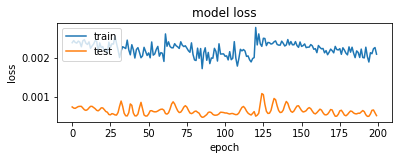

Prediction 161 of 244
dict_keys(['val_loss', 'loss'])


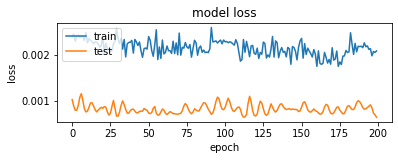

Prediction 162 of 244
dict_keys(['val_loss', 'loss'])


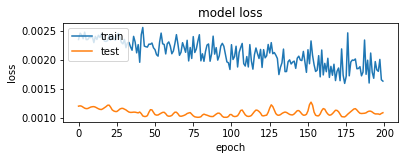

Prediction 163 of 244
dict_keys(['val_loss', 'loss'])


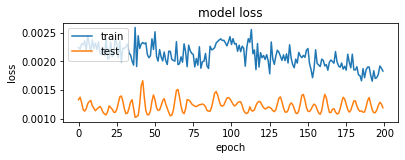

Prediction 164 of 244
dict_keys(['val_loss', 'loss'])


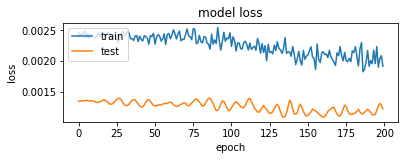

Prediction 165 of 244
dict_keys(['val_loss', 'loss'])


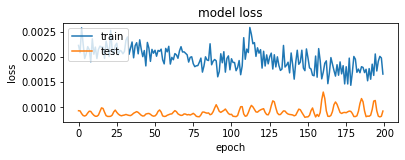

Prediction 166 of 244
dict_keys(['val_loss', 'loss'])


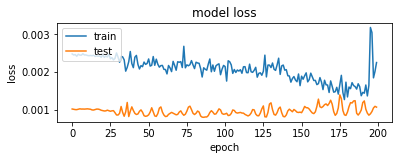

Prediction 167 of 244
dict_keys(['val_loss', 'loss'])


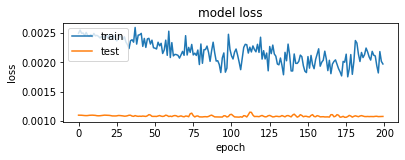

Prediction 168 of 244
dict_keys(['val_loss', 'loss'])


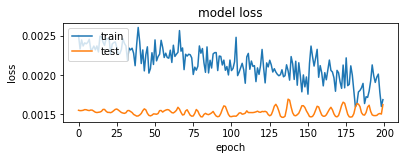

Prediction 169 of 244
dict_keys(['val_loss', 'loss'])


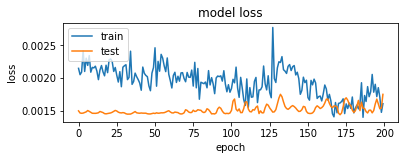

Prediction 170 of 244
dict_keys(['val_loss', 'loss'])


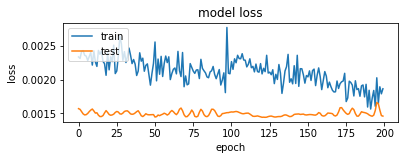

Prediction 171 of 244
dict_keys(['val_loss', 'loss'])


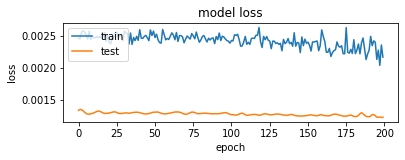

Prediction 172 of 244
dict_keys(['val_loss', 'loss'])


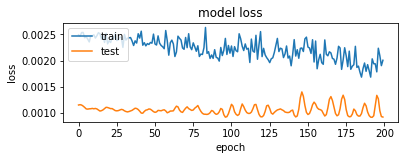

Prediction 173 of 244
dict_keys(['val_loss', 'loss'])


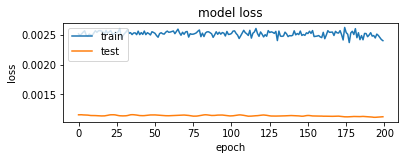

Prediction 174 of 244
dict_keys(['val_loss', 'loss'])


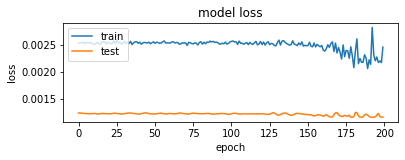

Prediction 175 of 244
dict_keys(['val_loss', 'loss'])


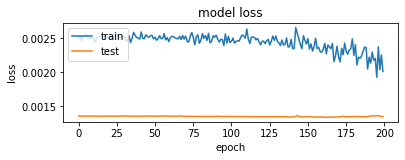

Prediction 176 of 244
dict_keys(['val_loss', 'loss'])


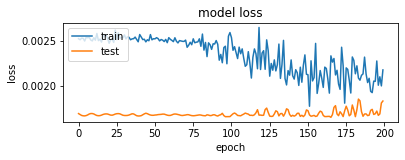

Prediction 177 of 244
dict_keys(['val_loss', 'loss'])


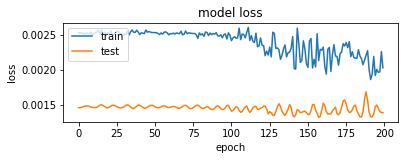

Prediction 178 of 244
dict_keys(['val_loss', 'loss'])


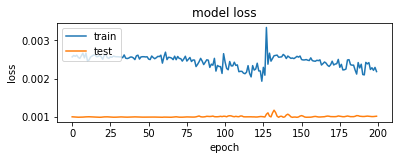

Prediction 179 of 244
dict_keys(['val_loss', 'loss'])


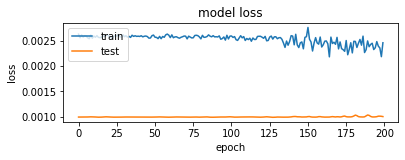

Prediction 180 of 244
dict_keys(['val_loss', 'loss'])


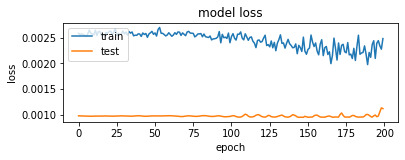

Prediction 181 of 244
dict_keys(['val_loss', 'loss'])


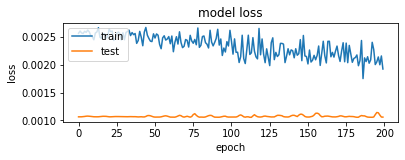

Prediction 182 of 244
dict_keys(['val_loss', 'loss'])


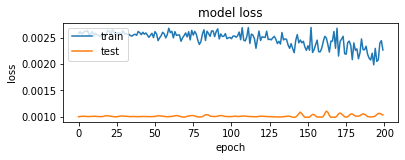

Prediction 183 of 244
dict_keys(['val_loss', 'loss'])


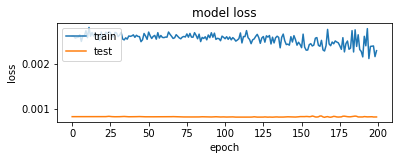

Prediction 184 of 244
dict_keys(['val_loss', 'loss'])


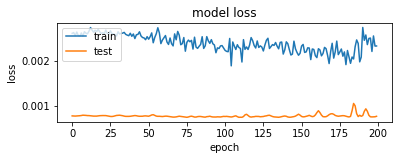

Prediction 185 of 244
dict_keys(['val_loss', 'loss'])


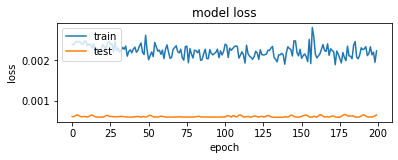

Prediction 186 of 244
dict_keys(['val_loss', 'loss'])


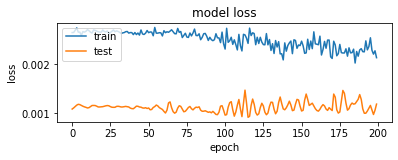

Prediction 187 of 244
dict_keys(['val_loss', 'loss'])


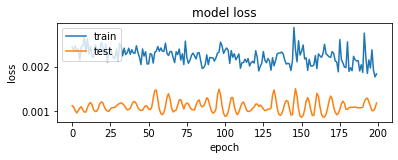

Prediction 188 of 244
dict_keys(['val_loss', 'loss'])


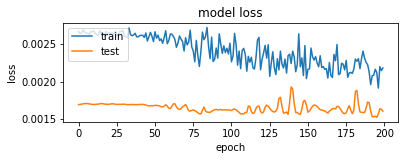

Prediction 189 of 244
dict_keys(['val_loss', 'loss'])


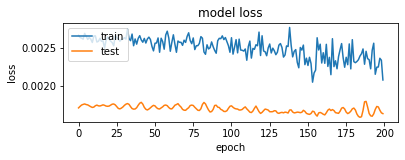

Prediction 190 of 244
dict_keys(['val_loss', 'loss'])


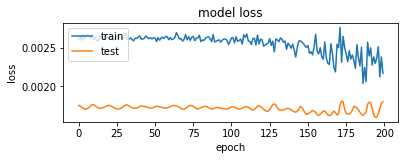

Prediction 191 of 244
dict_keys(['val_loss', 'loss'])


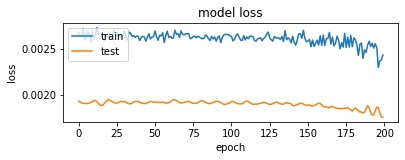

Prediction 192 of 244
dict_keys(['val_loss', 'loss'])


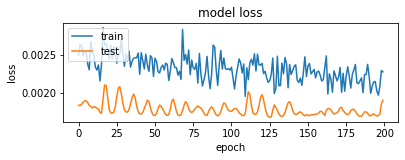

Prediction 193 of 244
dict_keys(['val_loss', 'loss'])


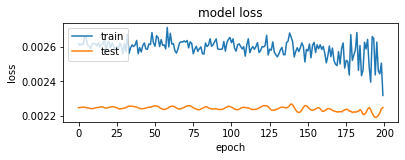

Prediction 194 of 244
dict_keys(['val_loss', 'loss'])


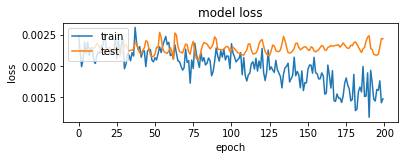

Prediction 195 of 244
dict_keys(['val_loss', 'loss'])


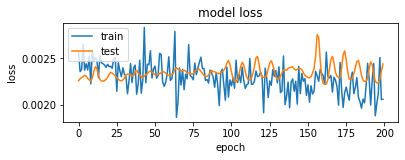

Prediction 196 of 244
dict_keys(['val_loss', 'loss'])


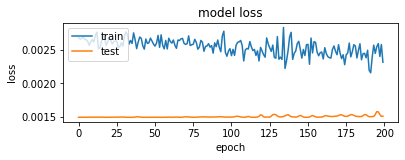

Prediction 197 of 244
dict_keys(['val_loss', 'loss'])


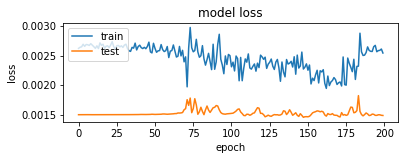

Prediction 198 of 244
dict_keys(['val_loss', 'loss'])


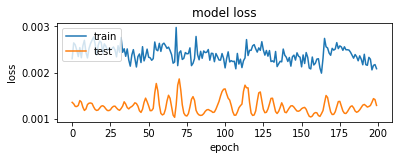

Prediction 199 of 244
dict_keys(['val_loss', 'loss'])


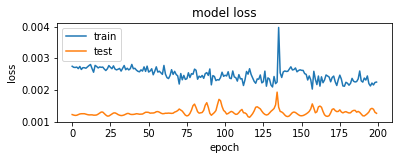

Prediction 200 of 244
dict_keys(['val_loss', 'loss'])


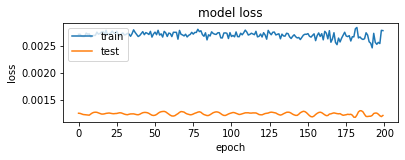

Prediction 201 of 244
dict_keys(['val_loss', 'loss'])


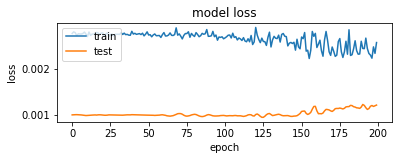

Prediction 202 of 244
dict_keys(['val_loss', 'loss'])


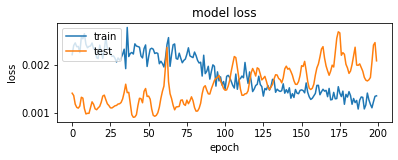

Prediction 203 of 244
dict_keys(['val_loss', 'loss'])


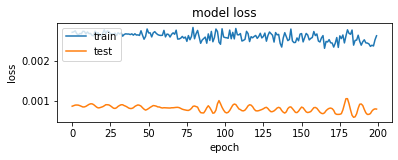

Prediction 204 of 244
dict_keys(['val_loss', 'loss'])


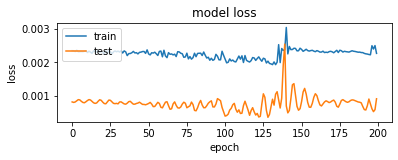

Prediction 205 of 244
dict_keys(['val_loss', 'loss'])


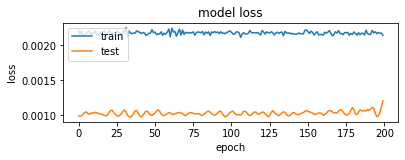

Prediction 206 of 244
dict_keys(['val_loss', 'loss'])


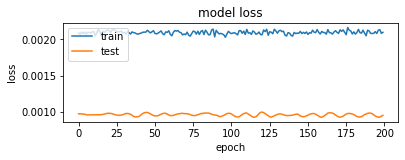

Prediction 207 of 244
dict_keys(['val_loss', 'loss'])


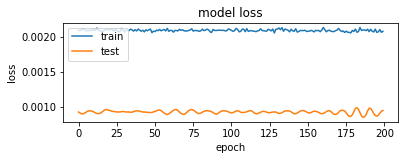

Prediction 208 of 244
dict_keys(['val_loss', 'loss'])


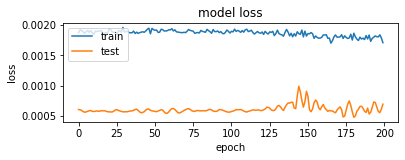

Prediction 209 of 244
dict_keys(['val_loss', 'loss'])


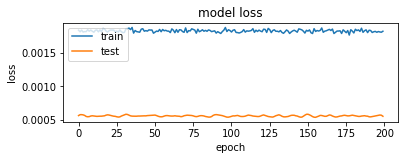

Prediction 210 of 244
dict_keys(['val_loss', 'loss'])


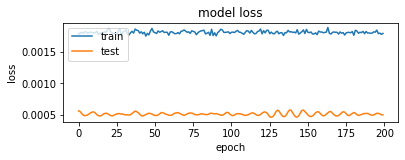

Prediction 211 of 244
dict_keys(['val_loss', 'loss'])


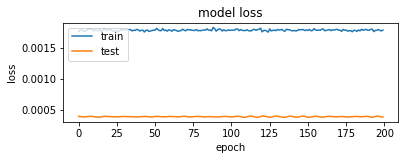

Prediction 212 of 244
dict_keys(['val_loss', 'loss'])


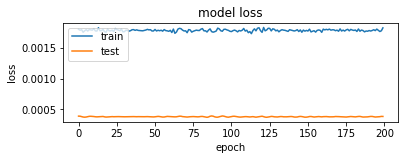

Prediction 213 of 244
dict_keys(['val_loss', 'loss'])


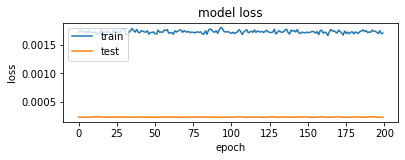

Prediction 214 of 244
dict_keys(['val_loss', 'loss'])


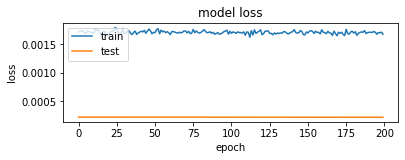

Prediction 215 of 244
dict_keys(['val_loss', 'loss'])


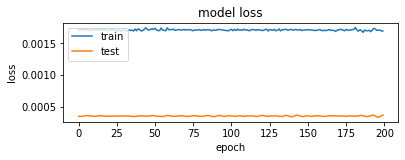

Prediction 216 of 244
dict_keys(['val_loss', 'loss'])


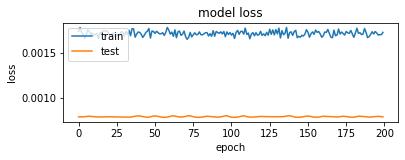

Prediction 217 of 244
dict_keys(['val_loss', 'loss'])


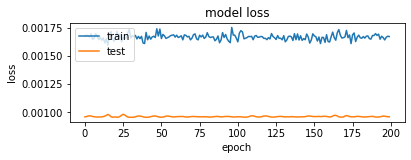

Prediction 218 of 244
dict_keys(['val_loss', 'loss'])


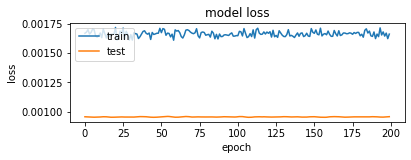

Prediction 219 of 244
dict_keys(['val_loss', 'loss'])


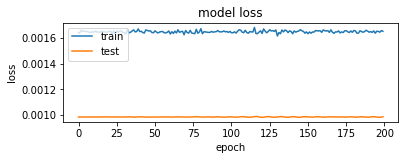

Prediction 220 of 244
dict_keys(['val_loss', 'loss'])


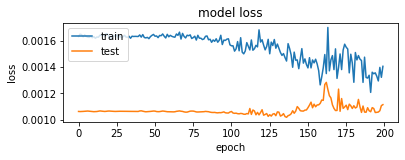

Prediction 221 of 244
dict_keys(['val_loss', 'loss'])


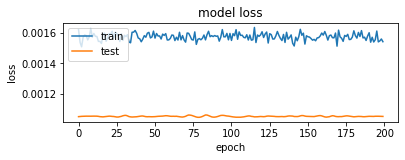

Prediction 222 of 244
dict_keys(['val_loss', 'loss'])


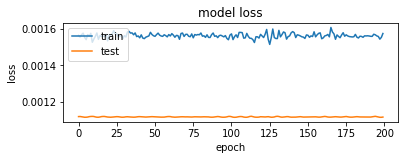

Prediction 223 of 244
dict_keys(['val_loss', 'loss'])


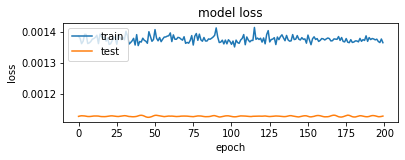

Prediction 224 of 244
dict_keys(['val_loss', 'loss'])


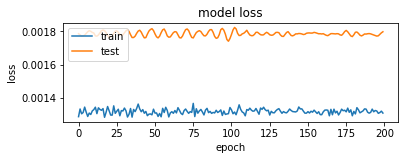

Prediction 225 of 244
dict_keys(['val_loss', 'loss'])


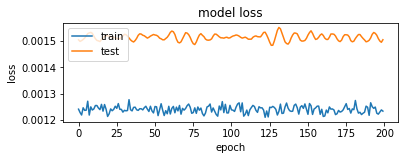

Prediction 226 of 244
dict_keys(['val_loss', 'loss'])


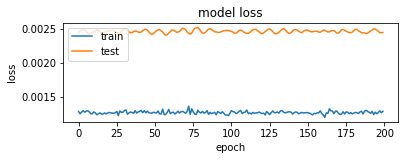

Prediction 227 of 244
dict_keys(['val_loss', 'loss'])


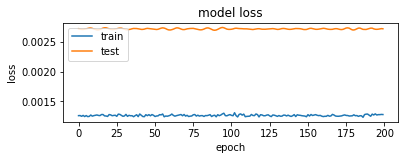

Prediction 228 of 244
dict_keys(['val_loss', 'loss'])


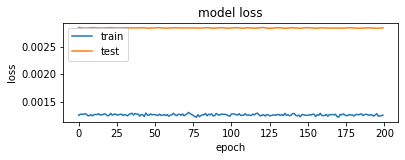

Prediction 229 of 244
dict_keys(['val_loss', 'loss'])


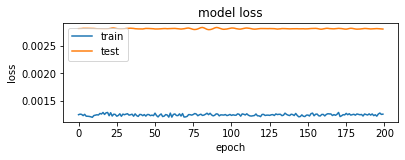

Prediction 230 of 244
dict_keys(['val_loss', 'loss'])


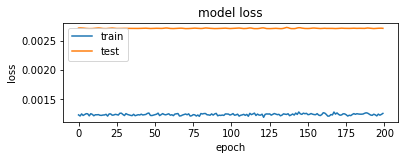

Prediction 231 of 244
dict_keys(['val_loss', 'loss'])


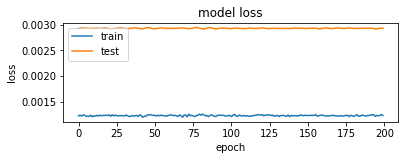

Prediction 232 of 244
dict_keys(['val_loss', 'loss'])


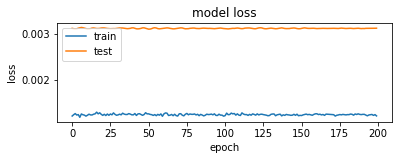

Prediction 233 of 244
dict_keys(['val_loss', 'loss'])


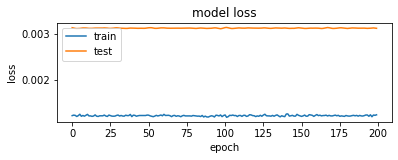

Prediction 234 of 244
dict_keys(['val_loss', 'loss'])


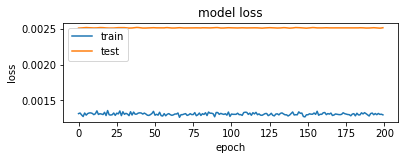

Prediction 235 of 244
dict_keys(['val_loss', 'loss'])


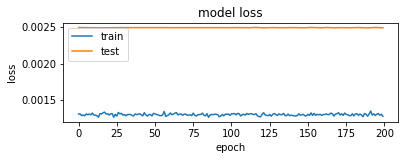

Prediction 236 of 244
dict_keys(['val_loss', 'loss'])


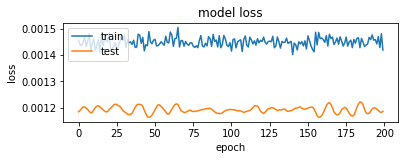

Prediction 237 of 244
dict_keys(['val_loss', 'loss'])


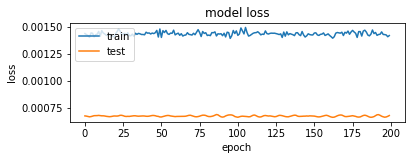

Prediction 238 of 244
dict_keys(['val_loss', 'loss'])


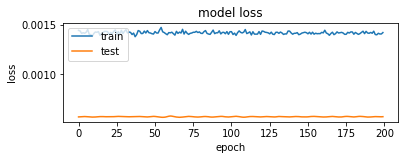

Prediction 239 of 244
dict_keys(['val_loss', 'loss'])


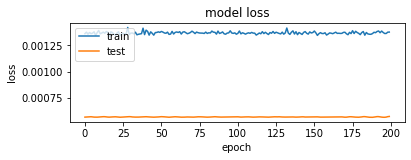

Prediction 240 of 244
dict_keys(['val_loss', 'loss'])


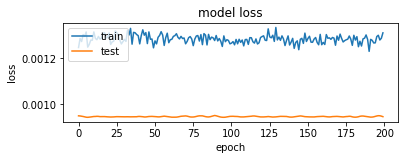

Prediction 241 of 244
dict_keys(['val_loss', 'loss'])


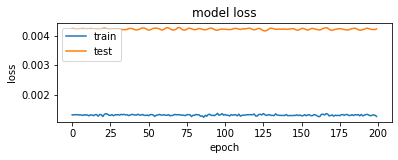

Prediction 242 of 244
dict_keys(['val_loss', 'loss'])


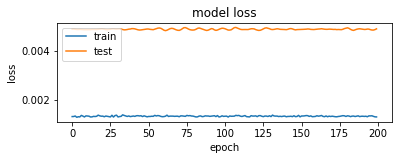

Prediction 243 of 244
dict_keys(['val_loss', 'loss'])


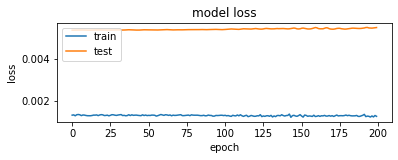

Prediction 244 of 244


In [16]:
pred_FIP_LSTM = predictLSTM(W_FIP_Xtrain, FIPYtrain, W_FIP_Xtest, FIPYtest, W_FIP_ForecastX)

In [17]:
LSTM_FIP_Forecast = pd.DataFrame(pred_FIP_LSTM)

In [18]:
FIPMonthly = FIPMonthly.loc['2000-05-01':].copy()
WOMonthly = WOMonthly.loc['2000-05-01':].copy()
SandPreturnsMonthly = SandPreturnsMonthly.loc['2000-05-01':].copy()
Tbills = Tbills.loc['2000-05-01':'2020-07-01'].copy()

In [19]:
def Create_Signal_Returns (data, name):
    
    data['Signal'] = data.copy()
    data[name]=np.nan
    data[name][data['Signal']>0]=1
    data[name][data['Signal']<0]=0
    data = data.iloc[0:length-1]
    
    return data

In [20]:
FIP_LSTM = Create_Signal_Returns(LSTM_FIP_Forecast, 'FIP_LSTM')
FIP_LSTM.shape

(243, 3)

In [21]:
FIP_LSTM = FIP_LSTM.iloc[0:length-1,:]

In [22]:
FIP_LSTM['Bill_Signal']=np.nan
FIP_LSTM['Bill_Signal'][FIP_LSTM['Signal']>0]=0
FIP_LSTM['Bill_Signal'][FIP_LSTM['Signal']<0]=1
FIP_LSTM.head()

0    Signal  FIP_LSTM  Bill_Signal
0  0.019700  0.019700       1.0          0.0
1  0.019883  0.019883       1.0          0.0
2  0.019937  0.019937       1.0          0.0
3  0.019687  0.019687       1.0          0.0
4  0.018522  0.018522       1.0          0.0

In [23]:
FIP_LSTM['TBills'] = Tbills.values
FIP_LSTM['FIPReturn'] = FIPMonthly.values
FIP_LSTM['Market'] = SandPreturnsMonthly['sandp'].values
FIP_LSTM['WO'] = WOMonthly.values
FIP_LSTM.head()

0    Signal  FIP_LSTM  Bill_Signal    TBills  FIPReturn    Market  \
0  0.019700  0.019700       1.0          0.0  0.005123  -0.010184 -0.025047   
1  0.019883  0.019883       1.0          0.0  0.005345  -0.004882 -0.013240   
2  0.019937  0.019937       1.0          0.0  0.004220   0.008822  0.014308   
3  0.019687  0.019687       1.0          0.0  0.004749  -0.083157 -0.021394   
4  0.018522  0.018522       1.0          0.0  0.005196   0.070359  0.057486   

         WO  
0 -0.010184  
1 -0.004882  
2  0.008822  
3 -0.083157  
4  0.070359

In [24]:
FIP_LSTM

0    Signal  FIP_LSTM  Bill_Signal    TBills  FIPReturn    Market  \
0    0.019700  0.019700       1.0          0.0  0.005123  -0.010184 -0.025047   
1    0.019883  0.019883       1.0          0.0  0.005345  -0.004882 -0.013240   
2    0.019937  0.019937       1.0          0.0  0.004220   0.008822  0.014308   
3    0.019687  0.019687       1.0          0.0  0.004749  -0.083157 -0.021394   
4    0.018522  0.018522       1.0          0.0  0.005196   0.070359  0.057486   
..        ...       ...       ...          ...       ...        ...       ...   
238  0.010627  0.010627       1.0          0.0  0.001344  -0.050345 -0.048844   
239  0.010722  0.010722       1.0          0.0  0.002145  -0.177528 -0.200545   
240  0.010479  0.010479       1.0          0.0  0.000097   0.103999  0.145804   
241  0.009491  0.009491       1.0          0.0  0.000062   0.080806  0.079492   
242  0.010170  0.010170       1.0          0.0  0.000126  -0.000094  0.019678   

           WO  
0   -0.010184  
1   -0.004882  
2    0.008822  
3   -0.083157  
4    0.070359  
..        ...  
238 -0.050345  
239 -0.177528  
240  0.103999  
241  0.080806  
242 -0.000094  

[243 rows x 8 columns]

In [25]:
FIP_LSTM['LSTM_Return'] = FIP_LSTM['FIPReturn']*FIP_LSTM['FIP_LSTM'].values
FIP_LSTM['TBills_Return'] = FIP_LSTM['TBills']*FIP_LSTM['Bill_Signal'].values
FIP_LSTM['Final_Portfolio'] = FIP_LSTM['TBills_Return']+FIP_LSTM['LSTM_Return'].values

#Subtract transaction cost
FIP_LSTM['Final_Portfolio'] = FIP_LSTM['Final_Portfolio']*0.997
FIP_LSTM.tail()

0    Signal  FIP_LSTM  Bill_Signal    TBills  FIPReturn    Market  \
238  0.010627  0.010627       1.0          0.0  0.001344  -0.050345 -0.048844   
239  0.010722  0.010722       1.0          0.0  0.002145  -0.177528 -0.200545   
240  0.010479  0.010479       1.0          0.0  0.000097   0.103999  0.145804   
241  0.009491  0.009491       1.0          0.0  0.000062   0.080806  0.079492   
242  0.010170  0.010170       1.0          0.0  0.000126  -0.000094  0.019678   

           WO  LSTM_Return  TBills_Return  Final_Portfolio  
238 -0.050345    -0.050345            0.0        -0.050194  
239 -0.177528    -0.177528            0.0        -0.176995  
240  0.103999     0.103999            0.0         0.103687  
241  0.080806     0.080806            0.0         0.080564  
242 -0.000094    -0.000094            0.0        -0.000094

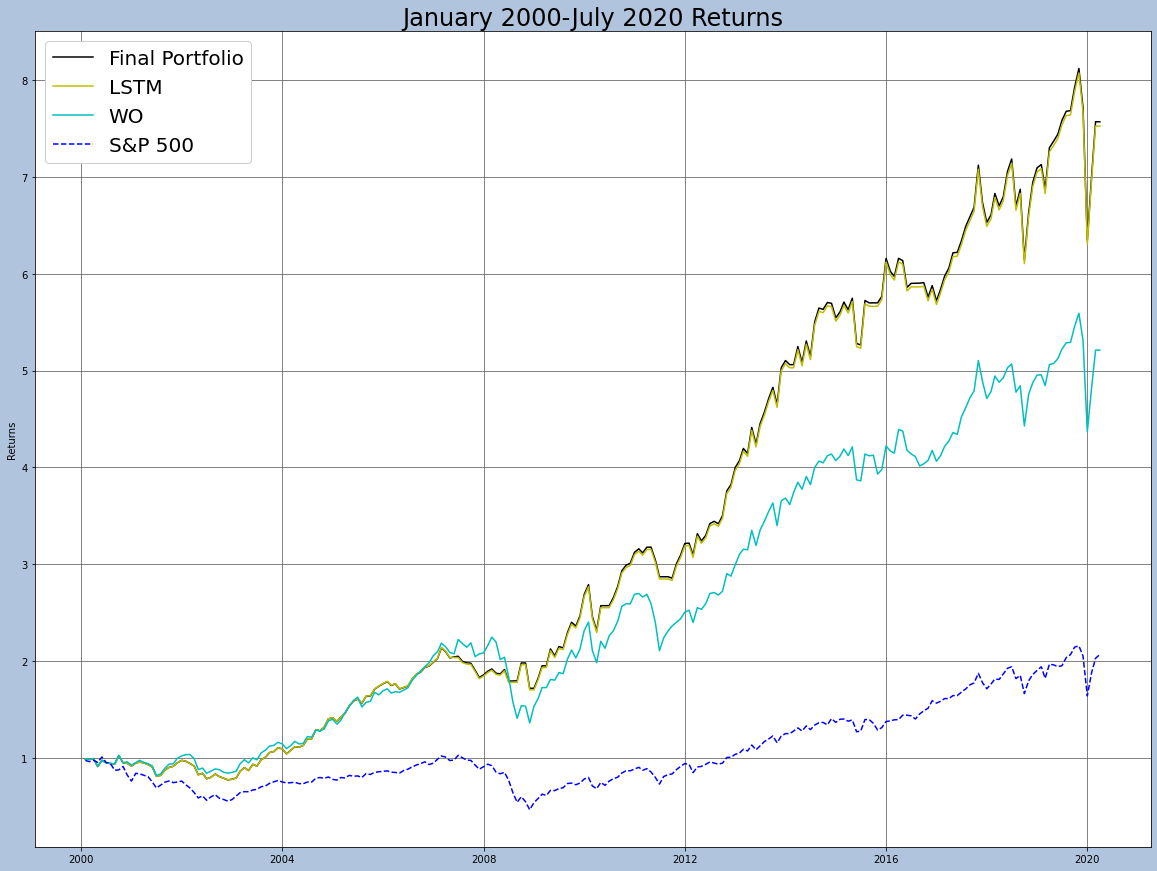

In [26]:
month = 0

FIP_LSTM['Finaltmp']=FIP_LSTM['Final_Portfolio']+1
FIP_LSTM['Finalcum']=np.cumprod(FIP_LSTM['Finaltmp'].iloc[month:])

FIP_LSTM['LSTMtmp']=FIP_LSTM['LSTM_Return']+1
FIP_LSTM['LSTMcum']=np.cumprod(FIP_LSTM['LSTMtmp'].iloc[month:])

FIP_LSTM['WOtmp']=FIP_LSTM['WO']+1
FIP_LSTM['WOcum']=np.cumprod(FIP_LSTM['WOtmp'].iloc[month:]) 

FIP_LSTM['MKTtmp']=FIP_LSTM['Market']+1
FIP_LSTM['MKTcum']=np.cumprod(FIP_LSTM['MKTtmp'].iloc[month:]) 


idx = pd.date_range('2000-01-01', periods=length-1, freq='M') # '2008-01-01', periods=135

plt.figure(figsize=(20,15)).patch.set_facecolor('lightsteelblue')
ax = plt.axes()
ax.set_facecolor("white")
plt.rcParams.update({'font.size': 20})
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.plot(idx, (FIP_LSTM['Finalcum'].iloc[month:]), 'k', label='Final Portfolio')
plt.plot(idx, (FIP_LSTM['LSTMcum'].iloc[month:]), 'y', label='LSTM')
plt.plot(idx, (FIP_LSTM['WOcum'].iloc[month:]), 'c', label='WO')
plt.plot(idx, (FIP_LSTM['MKTcum'].iloc[month:]), 'b--', label='S&P 500')
plt.title("January 2000-July 2020 Returns")                           
plt.ylabel('Returns')
plt.legend(facecolor='white', framealpha=1)
plt.show()
#plt.savefig('regular-cumret-sub.png', bbox_inches='tight')

In [27]:
def max_drawdown(X):
    mdd = 0
    peak = X.iloc[0]
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return mdd

def performance_measures(inp, mkt): 
    excess=inp-mkt
    D = len(inp)
    anret=inp.add(1).prod() ** (12 / D) - 1
    anvol=inp.std()*(math.sqrt(12))
    

    print('Mean: ', inp.mean())
    print('Max: ', inp.max())
    print('Min: ', inp.min())
    print('Ann. Return: ', anret)
    print('Ann. Volatility: ', anvol)
    print('Sharpe Ratio: ', anret/anvol) 
    print('Kurtosis: ', kurtosis(inp))
    print('Skewness: ', skew(inp))
    print('MDD: ', max_drawdown((inp+1).cumprod()))

In [28]:
performance_measures(FIP_LSTM['Final_Portfolio'],FIP_LSTM['Market'].values)

Mean:  0.0092306519192404
Max:  0.11120481983493816
Min:  -0.17699500116979333
Ann. Return:  0.10512055222464078
Ann. Volatility:  0.14360035370637284
Sharpe Ratio:  0.7320354686562004
Kurtosis:  2.0808544652371106
Skewness:  -0.6437874112998104
MDD:  0.24580811321206664


In [29]:
performance_measures(FIP_LSTM['LSTM_Return'],FIP_LSTM['Market'].values)

Mean:  0.009211535431295605
Max:  0.11153943814938631
Min:  -0.177527583921558
Ann. Return:  0.10479585474930686
Ann. Volatility:  0.14406194322973115
Sharpe Ratio:  0.7274360764535304
Kurtosis:  2.073824338421252
Skewness:  -0.6401183221120809
MDD:  0.24650617638355857


In [30]:
performance_measures(FIP_LSTM['WO'],FIP_LSTM['Market'].values)

Mean:  0.007856058890792696
Max:  0.1257219286987381
Min:  -0.177527583921558
Ann. Return:  0.08493796402957843
Ann. Volatility:  0.15667851526255736
Sharpe Ratio:  0.5421162173208103
Kurtosis:  1.7030283685173648
Skewness:  -0.7962454140371541
MDD:  0.39428512937304216


In [31]:
performance_measures(FIP_LSTM['FIPReturn'],FIP_LSTM['Market'].values)

Mean:  0.008808441543736147
Max:  0.11153943814938631
Min:  -0.177527583921558
Ann. Return:  0.097242956880492
Ann. Volatility:  0.15718621696888777
Sharpe Ratio:  0.6186481153098782
Kurtosis:  2.073063998017343
Skewness:  -0.7761089452700124
MDD:  0.38824481048671844


# ETF Selector

In [32]:
def ETFSelector (data, Range1, Range2, Range3, Range4):
    df = data.T.copy()
    
    for clmn in df.columns:
        df[clmn] = df[clmn].rank(method='max')
    df
    
    df2 = df.T.copy()
    
    high1=[]
    high2=[]
    high3=[]
    high4=[]
    
    for x in range(len(df2)):
        tmp1 = (df2 == Range1).idxmax(axis=1)[x]
        high1.append(tmp1)
        tmp2 = (df2 == Range2).idxmax(axis=1)[x]
        high2.append(tmp2)
        tmp3 = (df2 == Range3).idxmax(axis=1)[x]
        high3.append(tmp3)
        tmp4 = (df2 == Range4).idxmax(axis=1)[x]
        high4.append(tmp4)
    df2['high1'] = high1
    df2['high2'] = high2
    df2['high3'] = high3
    df2['high4'] = high4
    return df2

In [33]:
def hLookup (RankedReturns, Column, RawData):
    
    '''RankedReturns is output of ETFselector function
    Column is the column name hlookup will be used on and then named
    RawData is the raw excel data'''
    
    high = RankedReturns.loc[:,Column].copy()
    
    returnshigh = RawData.pct_change().dropna()
    
    returnshigh = returnshigh.join(high,how='outer')
    returnshigh = returnshigh.dropna()
    returnshigh[Column] = returnshigh.lookup(returnshigh.index, returnshigh[Column])
    returnshigh = returnshigh[Column].copy()
    return returnshigh

In [34]:
data = pd.read_excel('EqualSectorsDailyForecast.xlsx', index_col="date")

In [35]:
data

Energy  Financials  Industrials  Materials  Utilities  \
date                                                                
1989-12-29  353.40      353.40       353.40     353.40     353.40   
1990-01-01  353.40      353.40       353.40     353.40     353.40   
1990-01-02  355.81      359.34       360.51     361.22     356.48   
1990-01-03  351.34      358.99       360.35     361.55     353.20   
1990-01-04  346.44      357.12       359.59     361.01     347.77   
...            ...         ...          ...        ...        ...   
2020-08-10     NaN         NaN          NaN        NaN        NaN   
2020-08-11     NaN         NaN          NaN        NaN        NaN   
2020-08-12     NaN         NaN          NaN        NaN        NaN   
2020-08-13     NaN         NaN          NaN        NaN        NaN   
2020-08-14     NaN         NaN          NaN        NaN        NaN   

            Consumer Disc  Communication  Consumer Stap  Health    Tech  
date                                                                     
1989-12-29         353.40         353.40         353.40  353.40  353.40  
1990-01-01         353.40         353.40         353.40  353.40  353.40  
1990-01-02         363.21         357.16         357.22  358.90  364.89  
1990-01-03         361.85         354.03         356.19  359.19  363.99  
1990-01-04         359.18         344.35         353.68  356.24  361.95  
...                   ...            ...            ...     ...     ...  
2020-08-10            NaN            NaN            NaN     NaN     NaN  
2020-08-11            NaN            NaN            NaN     NaN     NaN  
2020-08-12            NaN            NaN            NaN     NaN     NaN  
2020-08-13            NaN            NaN            NaN     NaN     NaN  
2020-08-14            NaN            NaN            NaN     NaN     NaN  

[7991 rows x 10 columns]

In [40]:
SandP = pd.read_excel('SandP2.xlsx', index_col="date")
SandP = SandP.copy()
SandPreturns = SandP.pct_change().dropna()
SandPreturns = SandPreturns.loc['1990-01-02':'2020-08-03'].copy()
SandPreturns

sandp
date                
1990-01-02  0.019694
1990-01-03 -0.002720
1990-01-04 -0.006567
1990-01-05 -0.005490
1990-01-08  0.001887
...              ...
2020-07-28 -0.006890
2020-07-29  0.017167
2020-07-30 -0.007968
2020-07-31 -0.001389
2020-08-03  0.007181

[7980 rows x 1 columns]

In [41]:
MonthlyData = data.copy()
MonthlyData = MonthlyData.resample('BMS').first()

Monthly = MonthlyData.pct_change()

MonthlyLookback = MonthlyData.pct_change(periods=11)
MonthlyLookback = MonthlyLookback.shift(1).dropna()
MonthlyRank = ETFSelector(MonthlyLookback, 10.0, 9.0, 8.0, 7.0)
MonthlyRank = MonthlyRank.loc['1991-01-01':]
MonthlyRank.tail()

Energy  Financials  Industrials  Materials  Utilities  \
date                                                                
2020-04-01     1.0         6.0          5.0        3.0       10.0   
2020-05-01     1.0         3.0          5.0        4.0        8.0   
2020-06-01     1.0         3.0          4.0        5.0        7.0   
2020-07-01     1.0         3.0          5.0        4.0        7.0   
2020-08-03     1.0         2.0          6.0        4.0        5.0   

            Consumer Disc  Communication  Consumer Stap  Health  Tech  \
date                                                                    
2020-04-01            2.0            4.0            8.0     7.0   9.0   
2020-05-01            2.0            6.0            9.0    10.0   7.0   
2020-06-01            2.0            6.0            8.0    10.0   9.0   
2020-07-01            2.0            6.0            8.0    10.0   9.0   
2020-08-03            3.0            7.0            8.0     9.0  10.0   

                high1          high2          high3          high4  
date                                                                
2020-04-01  Utilities           Tech  Consumer Stap         Health  
2020-05-01     Health  Consumer Stap      Utilities           Tech  
2020-06-01     Health           Tech  Consumer Stap      Utilities  
2020-07-01     Health           Tech  Consumer Stap      Utilities  
2020-08-03       Tech         Health  Consumer Stap  Communication

In [42]:
FIPMonthly = data.pct_change().dropna()
FIPMonthly = FIPMonthly.loc['1990-01-02':'2020-08-03'].copy()

FIPMonthly2 = FIPMonthly.subtract(SandPreturns.values,axis='columns')

FIPMonthly2[FIPMonthly2>0]=1
FIPMonthly2[FIPMonthly2<=0]=0

FIPMonthly2 = FIPMonthly2.rolling(length-2).sum()
FIPMonthly2 = FIPMonthly2.div(length-2).multiply(100)
FIPMonthly2 = FIPMonthly2.shift(22)
FIPMonthly2 = FIPMonthly2.dropna()
FIPMonthly2 = FIPMonthly2.iloc[:,0:10]
FIPMonthly2 = FIPMonthly2.resample('BMS').first()
FIPMonthly2.tail()

Energy  Financials  Industrials  Materials  Utilities  \
date                                                                   
2020-04-01  41.322314   51.239669    46.694215  45.867769  47.933884   
2020-05-01  40.495868   49.586777    45.454545  47.933884  50.000000   
2020-06-01  41.322314   49.173554    46.694215  48.347107  49.586777   
2020-07-01  40.495868   48.760331    45.454545  46.280992  49.173554   
2020-08-03  41.322314   48.760331    45.867769  49.173554  49.173554   

            Consumer Disc  Communication  Consumer Stap     Health       Tech  
date                                                                           
2020-04-01      46.694215      49.173554      48.760331  54.132231  55.371901  
2020-05-01      45.454545      50.000000      49.586777  55.785124  55.371901  
2020-06-01      47.107438      50.413223      48.347107  54.545455  57.024793  
2020-07-01      47.520661      51.652893      47.520661  54.958678  55.785124  
2020-08-03      47.520661      51.239669      46.694215  54.958678  56.198347

In [43]:
FIPMonthly2['high1'] = MonthlyRank['high1'].copy()
FIPMonthly2['high2'] = MonthlyRank['high2'].copy()
FIPMonthly2['high3'] = MonthlyRank['high3'].copy()
FIPMonthly2['high4'] = MonthlyRank['high4'].copy()
FIPMonthly2.tail()

Energy  Financials  Industrials  Materials  Utilities  \
date                                                                   
2020-04-01  41.322314   51.239669    46.694215  45.867769  47.933884   
2020-05-01  40.495868   49.586777    45.454545  47.933884  50.000000   
2020-06-01  41.322314   49.173554    46.694215  48.347107  49.586777   
2020-07-01  40.495868   48.760331    45.454545  46.280992  49.173554   
2020-08-03  41.322314   48.760331    45.867769  49.173554  49.173554   

            Consumer Disc  Communication  Consumer Stap     Health       Tech  \
date                                                                            
2020-04-01      46.694215      49.173554      48.760331  54.132231  55.371901   
2020-05-01      45.454545      50.000000      49.586777  55.785124  55.371901   
2020-06-01      47.107438      50.413223      48.347107  54.545455  57.024793   
2020-07-01      47.520661      51.652893      47.520661  54.958678  55.785124   
2020-08-03      47.520661      51.239669      46.694215  54.958678  56.198347   

                high1          high2          high3          high4  
date                                                                
2020-04-01  Utilities           Tech  Consumer Stap         Health  
2020-05-01     Health  Consumer Stap      Utilities           Tech  
2020-06-01     Health           Tech  Consumer Stap      Utilities  
2020-07-01     Health           Tech  Consumer Stap      Utilities  
2020-08-03       Tech         Health  Consumer Stap  Communication

In [44]:
FIPMonthly2['1'] = FIPMonthly2.lookup(FIPMonthly2.index, FIPMonthly2['high1'])
FIPMonthly2['2'] = FIPMonthly2.lookup(FIPMonthly2.index, FIPMonthly2['high2'])
FIPMonthly2['3'] = FIPMonthly2.lookup(FIPMonthly2.index, FIPMonthly2['high3'])
FIPMonthly2['4'] = FIPMonthly2.lookup(FIPMonthly2.index, FIPMonthly2['high4'])
FIPtopMonthly = FIPMonthly2.iloc[:,14:19]
FIPtopMonthly.tail()

1          2          3          4
date                                                  
2020-04-01  47.933884  55.371901  48.760331  54.132231
2020-05-01  55.785124  49.586777  50.000000  55.371901
2020-06-01  54.545455  57.024793  48.347107  49.586777
2020-07-01  54.958678  55.785124  47.520661  49.173554
2020-08-03  56.198347  54.958678  46.694215  51.239669

In [45]:
FIPtopMonthly2 = ETFSelector (FIPtopMonthly, 4.0, 3.0, 2.0, 1.0)
FIPtopMonthly3 = FIPtopMonthly2.iloc[:,4:7]
FIPtopMonthly3.tail()

high1 high2 high3
date                        
2020-04-01     2     4     3
2020-05-01     1     4     3
2020-06-01     2     1     4
2020-07-01     2     1     4
2020-08-03     1     2     4

In [46]:
FIPtopMonthly3 = FIPtopMonthly3.astype(float)
FIPtopMonthly3[FIPtopMonthly3==1.0]=10.0
FIPtopMonthly3[FIPtopMonthly3==2.0]=9.0
FIPtopMonthly3[FIPtopMonthly3==3.0]=8.0
FIPtopMonthly3[FIPtopMonthly3==4.0]=7.0
FIPtopMonthly3.tail()

high1  high2  high3
date                           
2020-04-01    9.0    7.0    8.0
2020-05-01   10.0    7.0    8.0
2020-06-01    9.0   10.0    7.0
2020-07-01    9.0   10.0    7.0
2020-08-03   10.0    9.0    7.0

In [47]:
MonthlyRank2 = MonthlyRank.iloc[:,0:10].copy()
MonthlyRank2.tail()

Energy  Financials  Industrials  Materials  Utilities  \
date                                                                
2020-04-01     1.0         6.0          5.0        3.0       10.0   
2020-05-01     1.0         3.0          5.0        4.0        8.0   
2020-06-01     1.0         3.0          4.0        5.0        7.0   
2020-07-01     1.0         3.0          5.0        4.0        7.0   
2020-08-03     1.0         2.0          6.0        4.0        5.0   

            Consumer Disc  Communication  Consumer Stap  Health  Tech  
date                                                                   
2020-04-01            2.0            4.0            8.0     7.0   9.0  
2020-05-01            2.0            6.0            9.0    10.0   7.0  
2020-06-01            2.0            6.0            8.0    10.0   9.0  
2020-07-01            2.0            6.0            8.0    10.0   9.0  
2020-08-03            3.0            7.0            8.0     9.0  10.0

In [48]:
Monthly2 = MonthlyData.pct_change()
Monthly2 = Monthly2.loc['1991-01-01':]
Monthly2

x2 = MonthlyRank2.copy()
y2 = FIPtopMonthly3.copy()
y2 = y2.reset_index()
MonthlyReturns = Monthly2.copy()

FIP1_2 = y2['high1'].copy()
FIP2_2 = y2['high2'].copy()
FIP3_2 = y2['high3'].copy()

high1_2=[]
high2_2=[]
high3_2=[]
for p in range(len(x2)):
    tmp1_2 = (x2 == FIP1_2[p]).idxmax(axis=1)[p]
    high1_2.append(tmp1_2)
    tmp2_2 = (x2 == FIP2_2[p]).idxmax(axis=1)[p]
    high2_2.append(tmp2_2)
    tmp3_2 = (x2 == FIP3_2[p]).idxmax(axis=1)[p]
    high3_2.append(tmp3_2)
    
MonthlyReturns['high1'] = high1_2
MonthlyReturns['high2'] = high2_2
MonthlyReturns['high3'] = high3_2
MonthlyReturns.tail()

Energy  Financials  Industrials  Materials  Utilities  \
date                                                                  
2020-04-01 -0.479068   -0.308610    -0.249536  -0.228226  -0.208134   
2020-05-01  0.373361    0.153406     0.129444   0.166643   0.078188   
2020-06-01  0.104473    0.098492     0.106360   0.100549   0.069830   
2020-07-01 -0.038813   -0.013366     0.016712   0.012885  -0.025008   
2020-08-03  0.000000    0.000000     0.000000   0.000000   0.000000   

            Consumer Disc  Communication  Consumer Stap    Health      Tech  \
date                                                                          
2020-04-01      -0.355359      -0.214266      -0.123905 -0.149211 -0.200543   
2020-05-01       0.246988       0.145852       0.083995  0.149815  0.158211   
2020-06-01       0.134562       0.121503       0.048290  0.083291  0.110838   
2020-07-01      -0.002508       0.009362      -0.011371 -0.010515  0.021603   
2020-08-03       0.000000       0.000000       0.000000  0.000000  0.000000   

             high1   high2          high3  
date                                       
2020-04-01    Tech  Health  Consumer Stap  
2020-05-01  Health    Tech      Utilities  
2020-06-01    Tech  Health      Utilities  
2020-07-01    Tech  Health      Utilities  
2020-08-03    Tech  Health  Communication

# FIP ETF's to Buy For Following Month

In [49]:
Monthly = pd.read_pickle('data/Monthly.pkl')
Monthly2 = pd.read_pickle('data/MonthlyReturns.pkl')
WOMonthly = Monthly.iloc[:,14:15].copy()
FIPMonthly = Monthly2.iloc[:,16:17].copy()

In [50]:
FIP_LSTM_Signal = LSTM_FIP_Forecast.copy()

In [51]:
FIP_LSTM_Signal.iloc[length-1:,2:].values

array([[1.]])

In [52]:
#FIP_LSTM_Signal = Create_Signal_Returns(LSTM_FIP_Forecast, 'FIP_LSTM')

if FIP_LSTM_Signal.iloc[length-1:,2:].values==1.0:
    print(MonthlyReturns.loc['2020-08-03','high1'],MonthlyReturns.loc['2020-08-03','high2'],\
          MonthlyReturns.loc['2020-08-03','high3'])
else:
    print('Buy T-Bills')

Tech Health Communication


In [53]:
#Equal Weighted ETFS

#RYE - Equal Weight S&P 500 Energy ETF
#RYF - Equal Weight S&P 500 Financials ETF
#RGI - Equal Weight S&P 500 Industrials ETF
#RTM - Equal Weight S&P 500 Materials ETF
#RYU - Equal Weight S&P 500 Utilities ETF
#RCD - Equal Weight S&P 500 Consumer Discretionary ETF
#EWCO - Equal Weight S&P 500 Communicantion ETF
#RHS - Equal Weight S&P 500 Consumer Staples ETF
#RYH - Equal Weight S&P 500 Health ETF
#RYT - Equal Weight S&P 500 Technology ETF
#RSP - Equal Weight S&P 500 ETF

# Pyfolio

In [54]:
SandPreturnsMonthly2 = SandPreturnsMonthly.loc['2000-05-01':].copy()
SandPreturnsMonthly2['Final_Portfolio']= FIP_LSTM['Final_Portfolio'].values
SandPreturnsMonthly2 = SandPreturnsMonthly2.rename(columns={'sandp':'S&P 500'})
benchmark = SandPreturnsMonthly2.loc[:,'S&P 500'].copy()
returns = SandPreturnsMonthly2.loc[:,'Final_Portfolio']

Entire data start date: 2000-05-01
Entire data end date: 2020-07-01


Backtest Months: 11


Performance statistics   Backtest
annual_return                7.16
annual_volatility            0.66
sharpe_ratio                 3.54
calmar_ratio                29.12
stability_of_timeseries      0.99
max_drawdown                -0.25
omega_ratio                  1.83
sortino_ratio                5.46
skew                        -0.64
kurtosis                     2.08
tail_ratio                   1.24
common_sense_ratio          10.15
information_ratio            0.16
alpha                        1.64
beta                         0.66

TypeError: Already tz-aware, use tz_convert to convert.

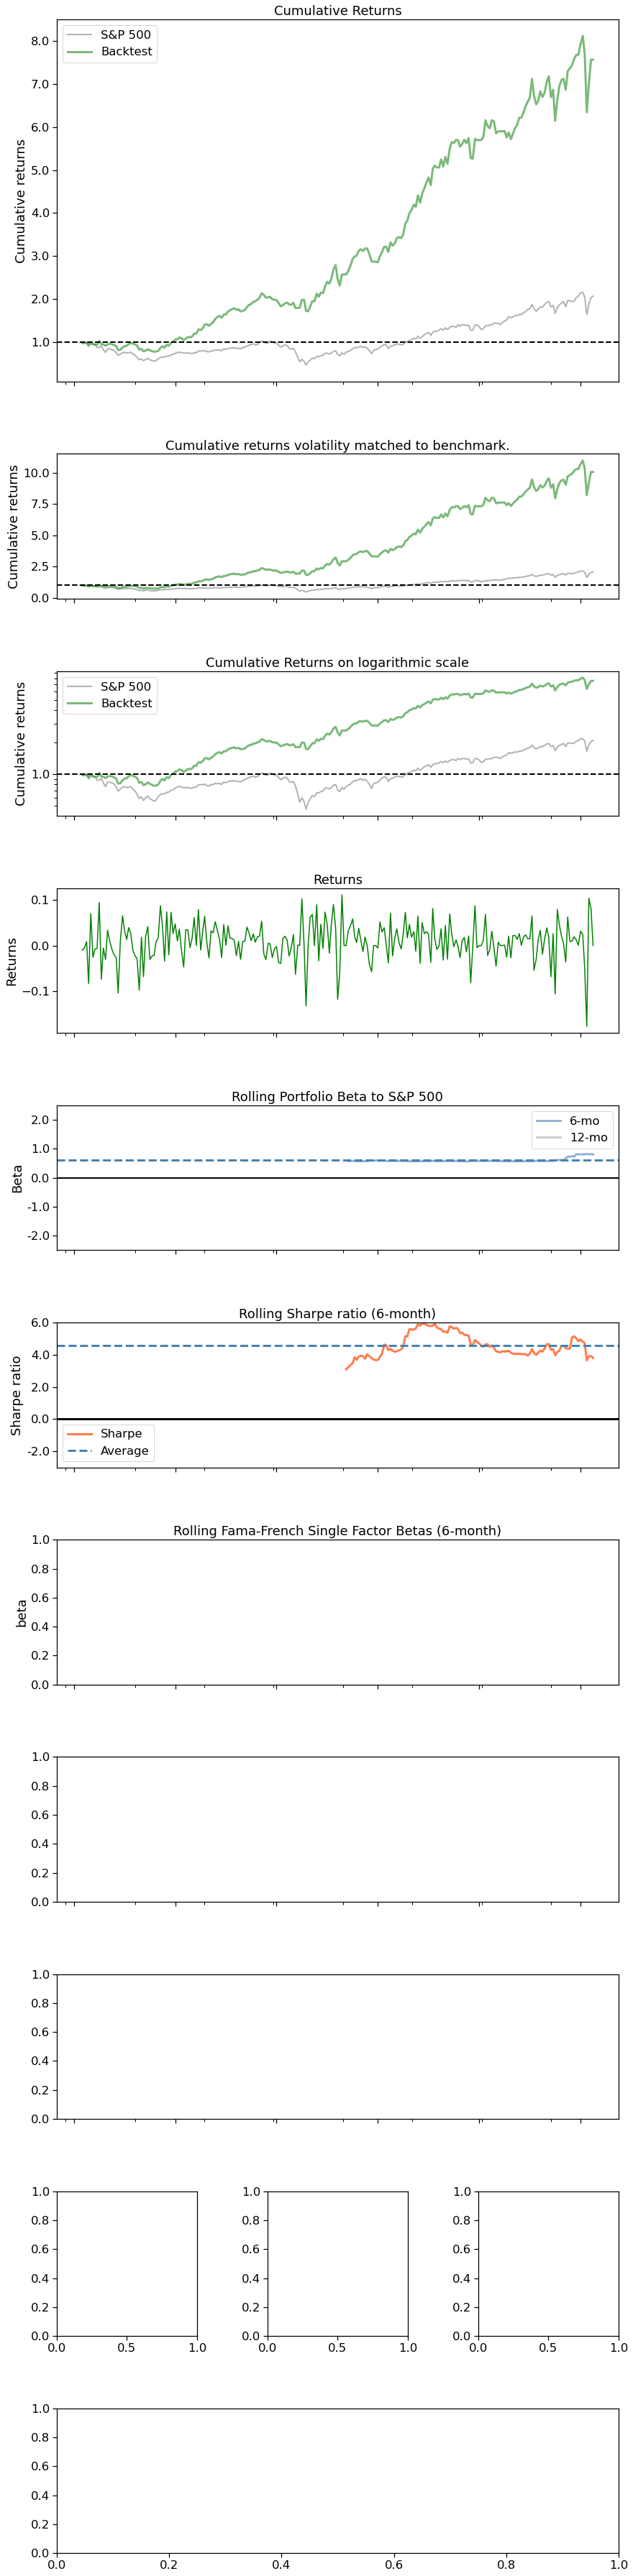

In [55]:
pf.create_returns_tear_sheet(returns, benchmark_rets=benchmark)